In [11]:
library(ggplot2)
library(coda)
library(R2jags)


# Exercise 1 #

given the following un-normalized posterior distribution:

$$
g(\theta \mid x) \propto \frac{1}{2} \exp -\frac{(\theta+3)^{2}}{2}+\frac{1}{2} \exp -\frac{(\theta-3)^{2}}{2}
$$

•draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

•use a Norm (0,1) as random-walk candidate density

•plot the sampled distribution

$$
\rho = \frac{f(s)}{f(\theta _t)} \frac{Q(\theta _t|s)}{Q(s|\theta _t)}
$$

if $\rho \geq \mathcal{U}(1) $ -> accepted

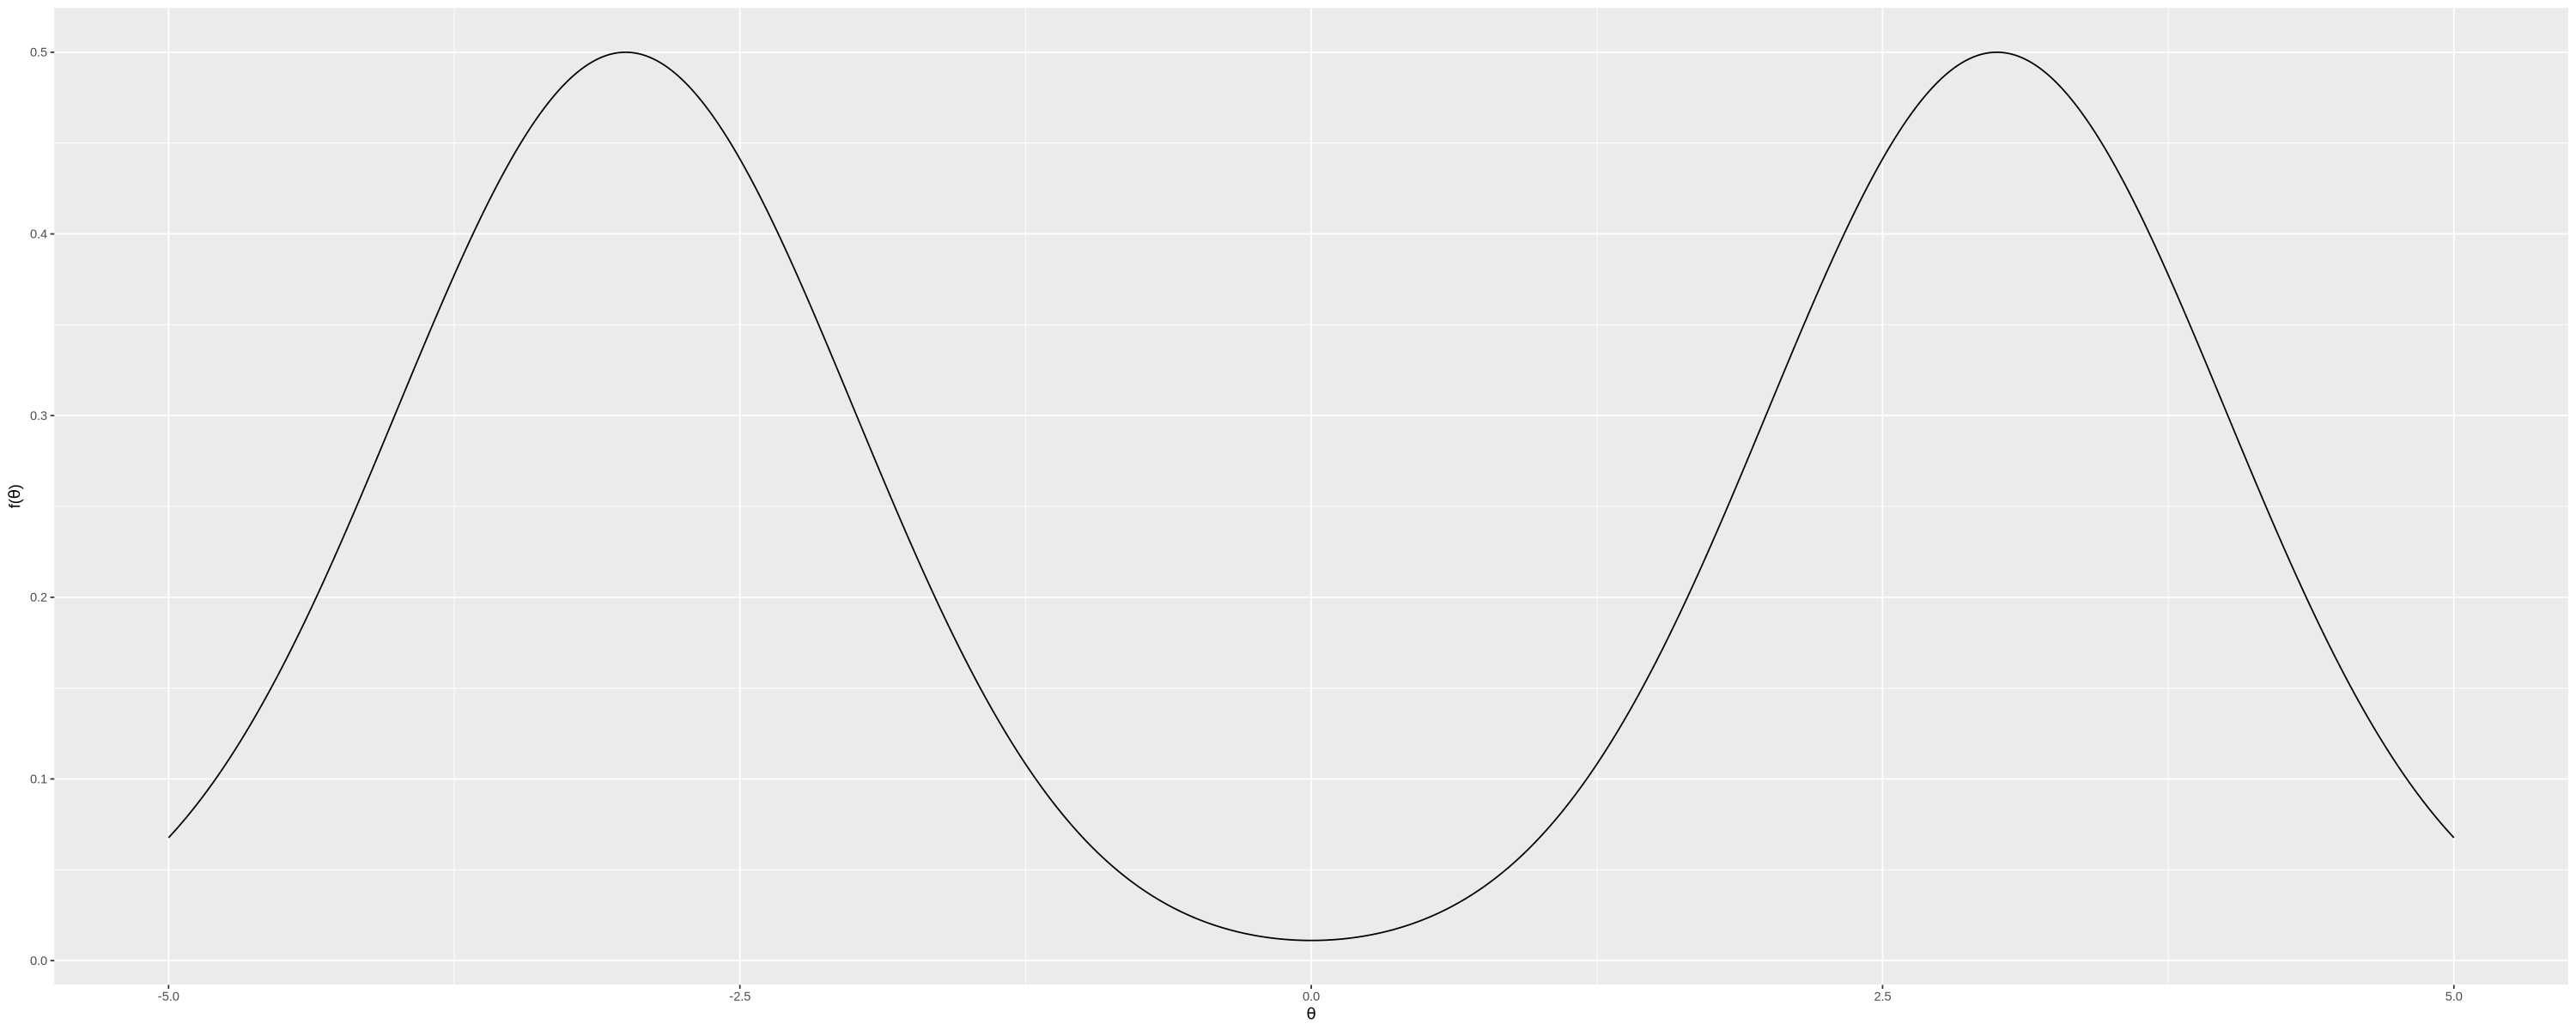

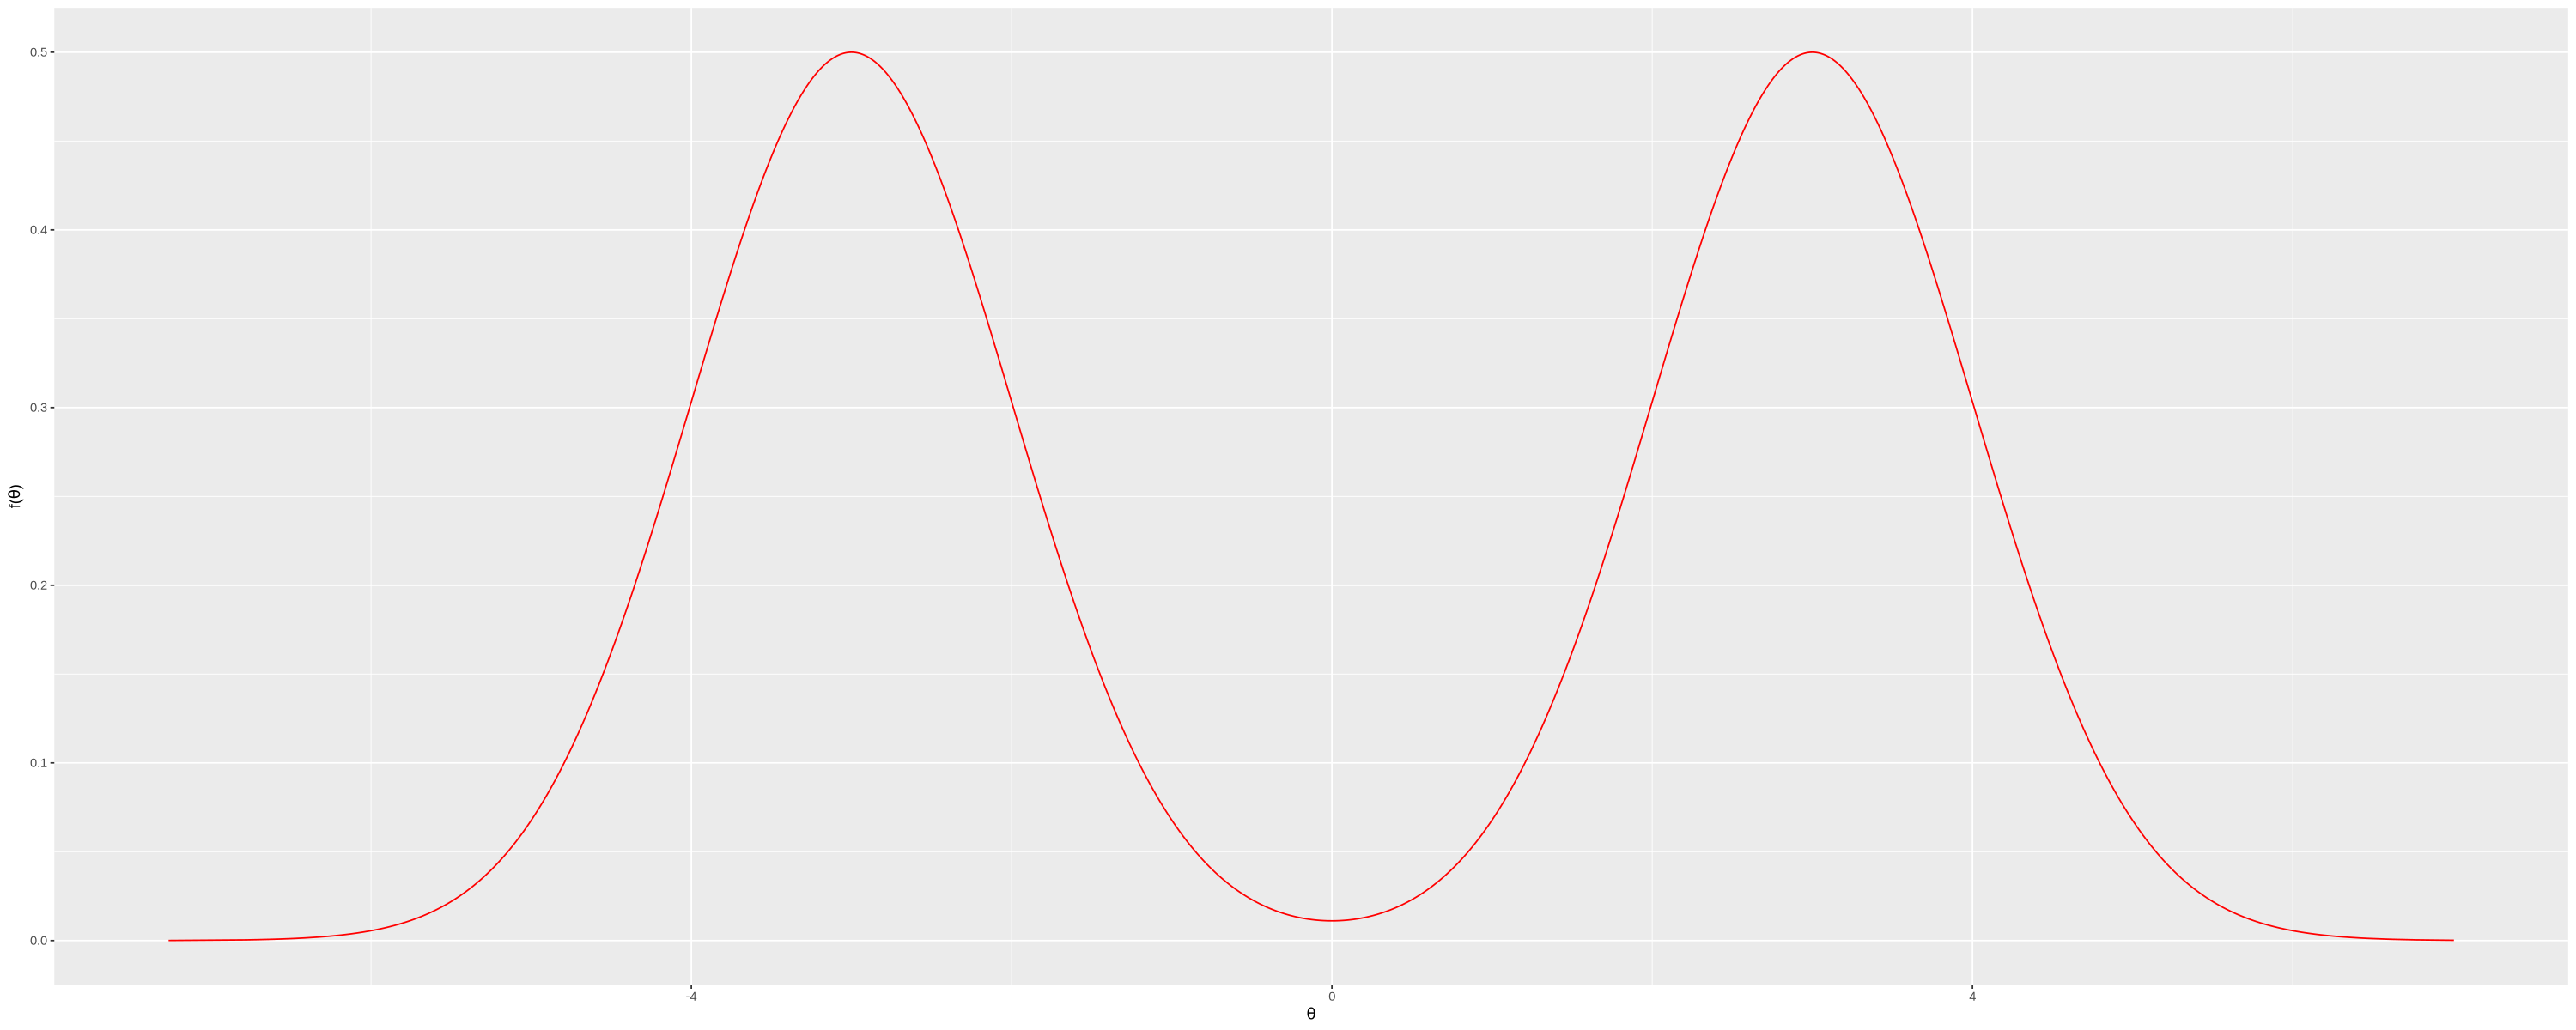

In [2]:
gfunc <- function(theta) {
    return(0.5 * exp(-((theta + 3)^2 / 2)) + 0.5 * exp(-(theta - 3)^2 / 2))
}

metropolis <- function(func, theta_init, n_samples) {
    # Initialization
    theta_curr <- theta_init
    func_curr <- func(theta_curr)
    func_samp <- matrix(data=NA, nrow=n_samples, ncol=2)
    #n_accept <- 0

    for (n in 1:n_samples) {
        # Extract the proposed state
        theta_prop <- rnorm(1, theta_curr, 1)
        func_prop <- func(theta_prop)
        Q_curr <- dnorm(theta_curr, theta_prop, 1) # Q(theta_t|s)
        Q_prop <- dnorm(theta_prop, theta_curr, 1) # Q(s|theta_t)
        rho <- (func_prop / func_curr) * (Q_curr / Q_prop) 

        if (rho >= runif(1)) {
            theta_curr <- theta_prop
            func_curr <- func_prop
            #n_accept <- n_accept + 1
        }
        func_samp[n, 1] <- func_curr
        func_samp[n, 2] <- theta_curr
    }
    return(func_samp)
}

# Plot the actual function
t = seq(-5, 5, length = 1e5)
df = data.frame(theta = t, func = gfunc(t))
#plot(t, log10(gfunc(t)), xlab = )
ggplot(df, aes(x = theta, y = func)) +
    geom_line(aes(x = theta, y = func)) +
    xlab(expression(theta)) + 
    ylab(expression(paste('f(',theta,')', sep='')))

# Testing
theta_init <- 1
n_samples <- 1e5

#set.seed(12345)
result <- metropolis(gfunc, theta_init, n_samples)
#result[, 1]
func_res = array(result[, 1])
theta_res = array(result[, 2])

#theta_space = seq(min(theta_res), max(theta_res), length = n_samples)
#print(theta_space)

# FIXA QUESTO !!!!
actual_func = gfunc(t) # dovresti usare theta_space ma crasha

#df_result = data.frame(theta_res = theta_res, func_res = func_res, actual_func = actual_func)

df_result = data.frame(theta_res = theta_res, func_res = func_res)
ggplot(df_result) +
    geom_line(aes(x = theta_res, y = func_res), color = 'red') +
    #geom_line(aes(x = theta_res, y = actual_func), color = 'blue') +
    xlab(expression(theta)) + 
    ylab(expression(paste('f(',theta,')', sep='')))
#plot(theta_res, func_res, xlab = expression(theta), ylab = expression(paste('f(',theta,')', sep='')))
#result


•analyze the chain with the CODA package and plot the chain autocorrelation

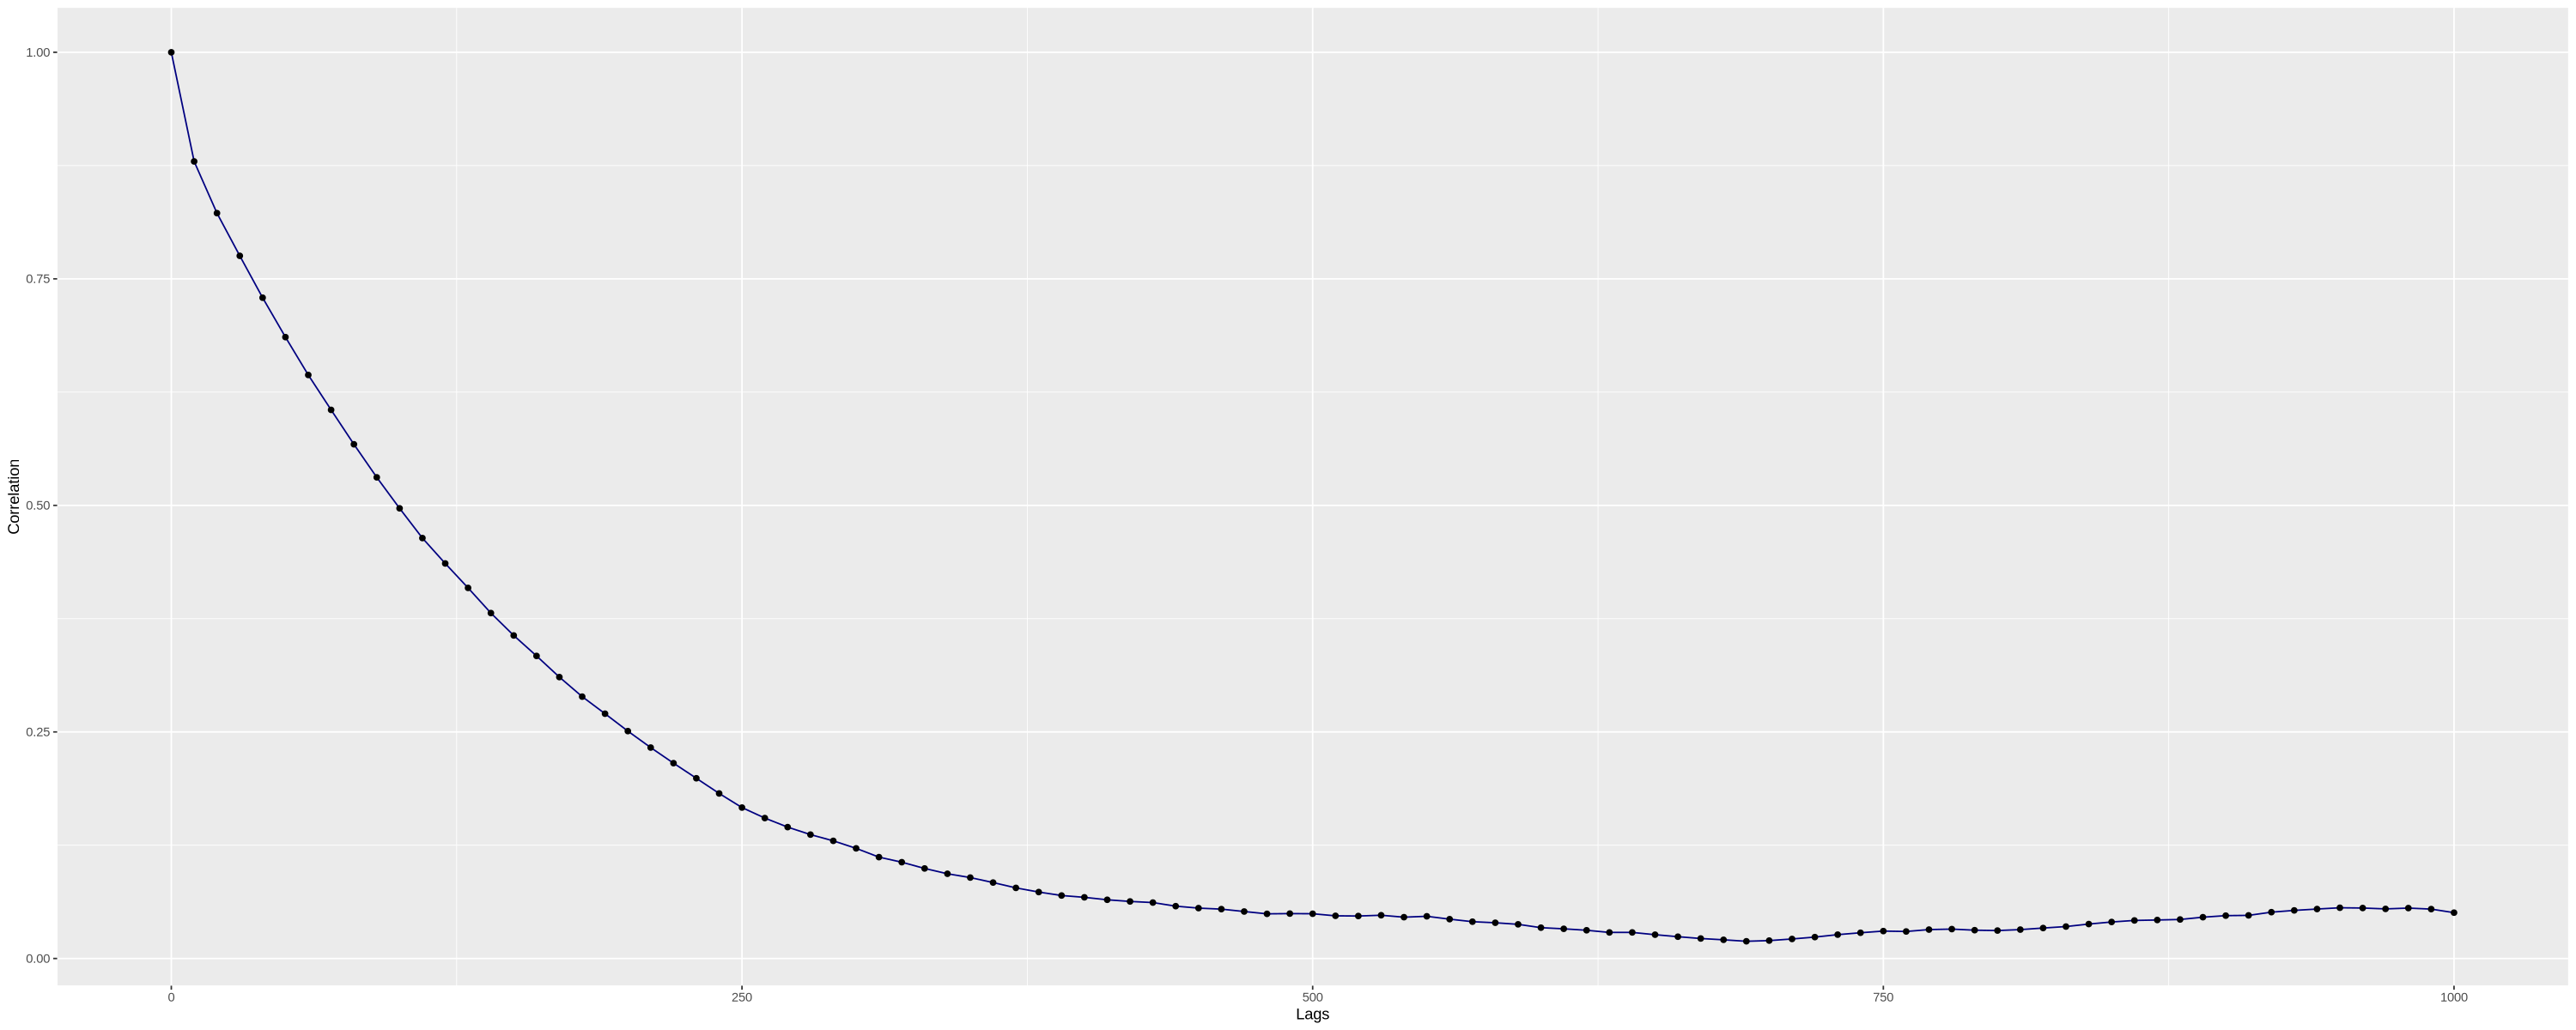

In [3]:
coda_chain = as.mcmc(theta_res)
#print(coda_chain)

lags = seq(0, 1000, 10)
corr = autocorr(coda_chain, lags)
#print(corr)

df = data.frame(lags = lags, corr = corr)

ggplot(df) +
    geom_line(aes(lags, corr), color = 'navyblue') +
    geom_point(aes(lags, corr)) +
    xlab("Lags") +
    ylab("Correlation")

•try to use different burn-in cycles and thinning and plot the corresponding posterior distribution
and the chain autocorrelation function. What are the best parameters ?

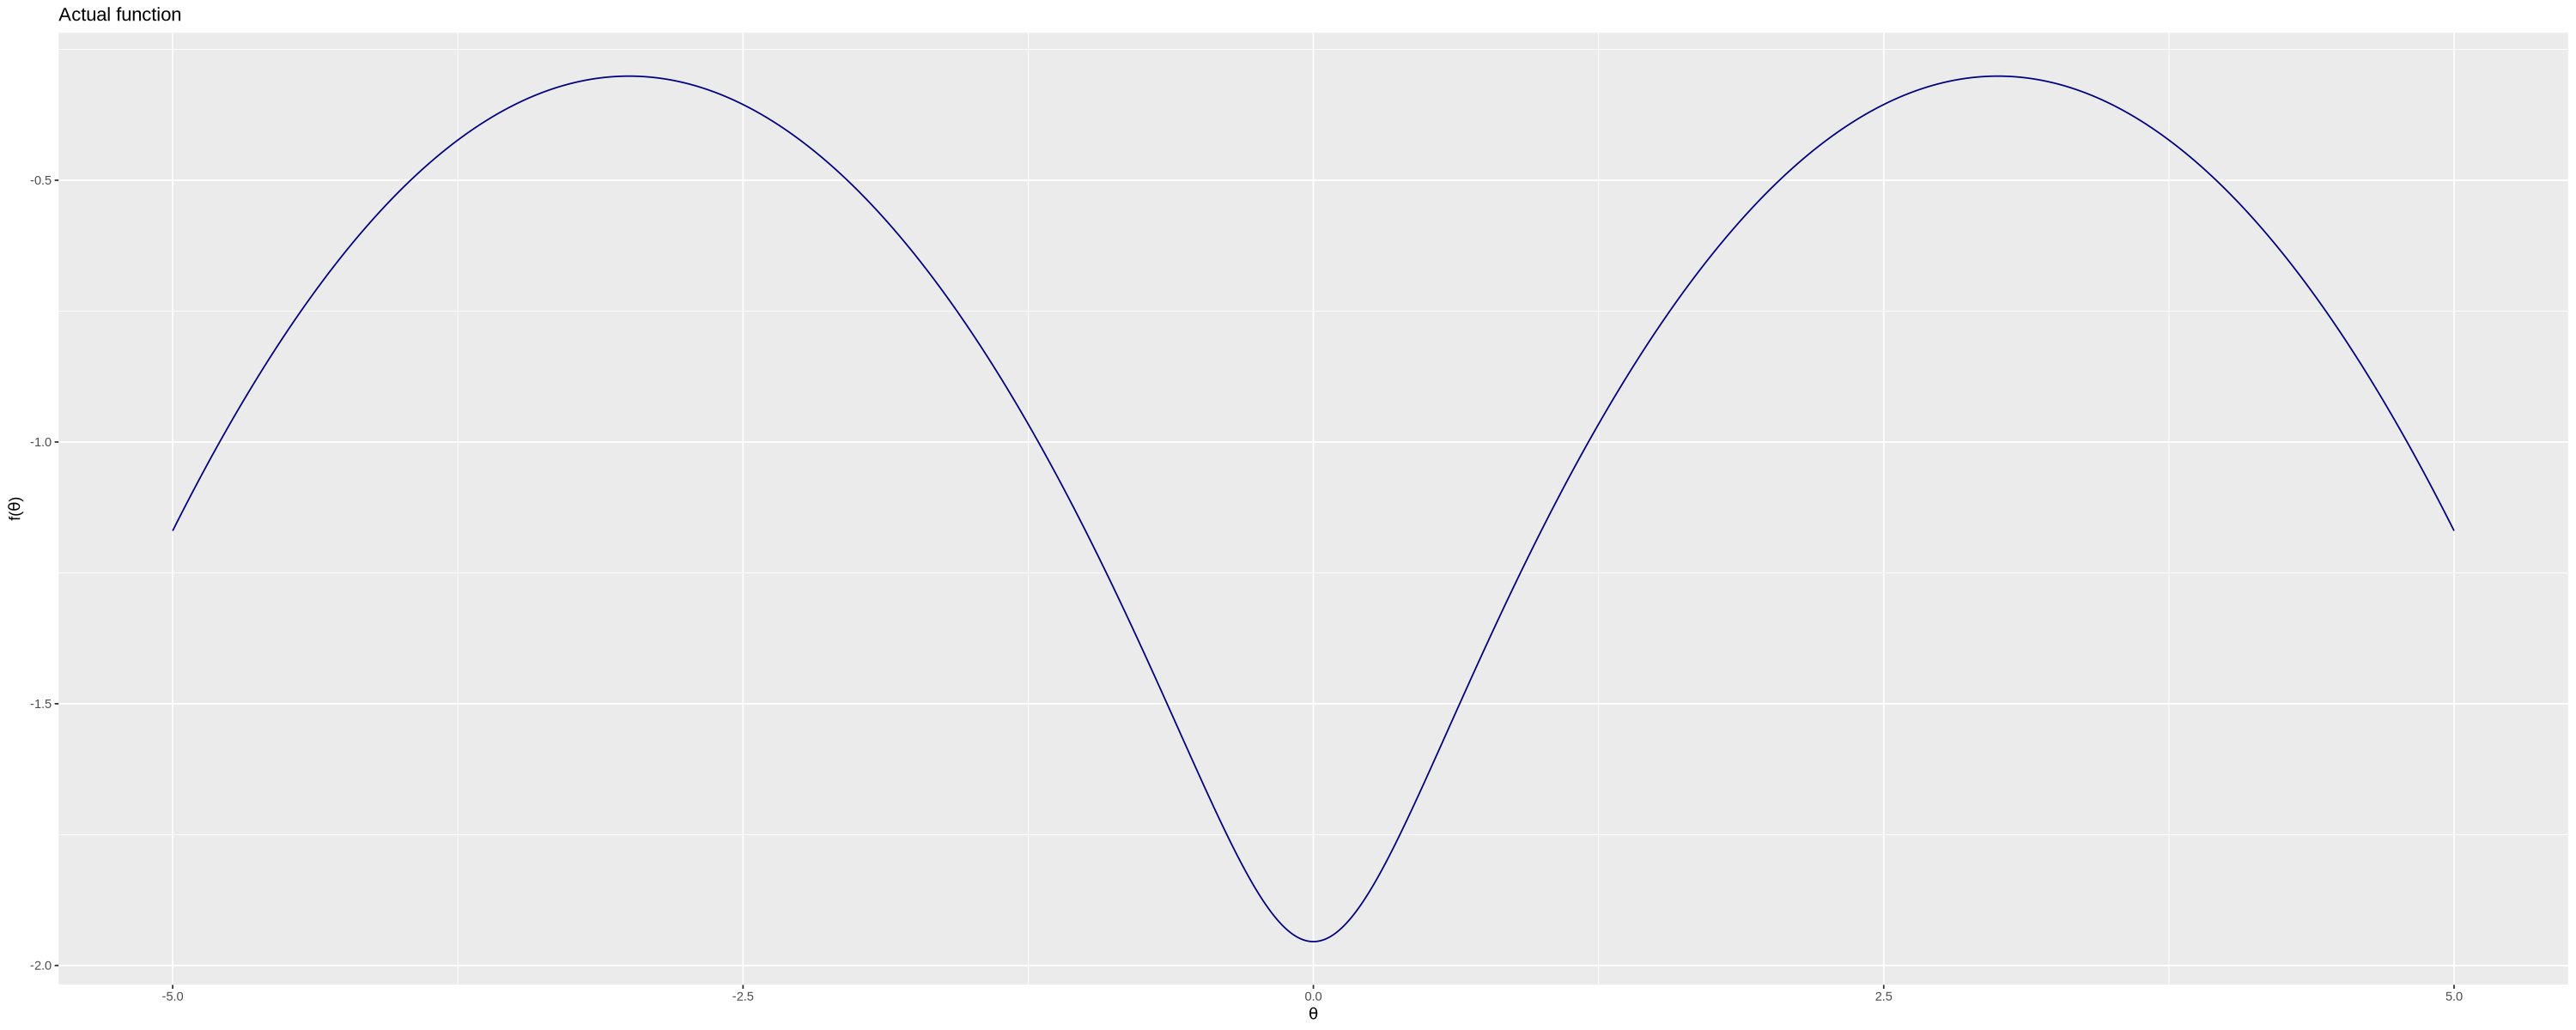

In [4]:
# Plot the actual function
t = seq(-5, 5, 10 / 1e5)
df = data.frame(theta = t, func = log10(gfunc(t)))
#plot(t, log10(gfunc(t)), xlab = )
ggplot(df, aes(x = theta, y = func)) +
    geom_line(aes(x = theta, y = func), color = 'navyblue') +
    labs(title = "Actual function") +
    xlab(expression(theta)) + 
    ylab(expression(paste('f(',theta,')', sep='')))

par(mfrow = c(2, 10))
n_samples <- 1e5
# Testing
for (theta in seq(-5, 5, 1)) {
    # Testing
    #print(theta)
    theta_init <- theta

    #set.seed(12345)
    result <- metropolis(gfunc, theta_init, n_samples)
    #result[, 1]
    func_res = array(result[, 1])
    theta_res = array(result[, 2])
    actual_func = gfunc(theta_res)
    df_result = data.frame(theta_res = theta_res, func_res = func_res, actual_func = actual_func)
    ggplot(df_result) +
        geom_line(aes(x = theta_res, y = func_res), color = 'red') +
        geom_line(aes(x = theta_res, y = actual_func), color = 'blue') +
        xlab(expression(theta)) + 
        ylab(expression(paste('f(',theta,')', sep='')))
    #plot(theta_res, func_res, xlab = expression(theta), ylab = expression(paste('f(',theta,')', sep='')))
    #result
}

[1] "The best params are: burn in = 0 , thinning = 1"


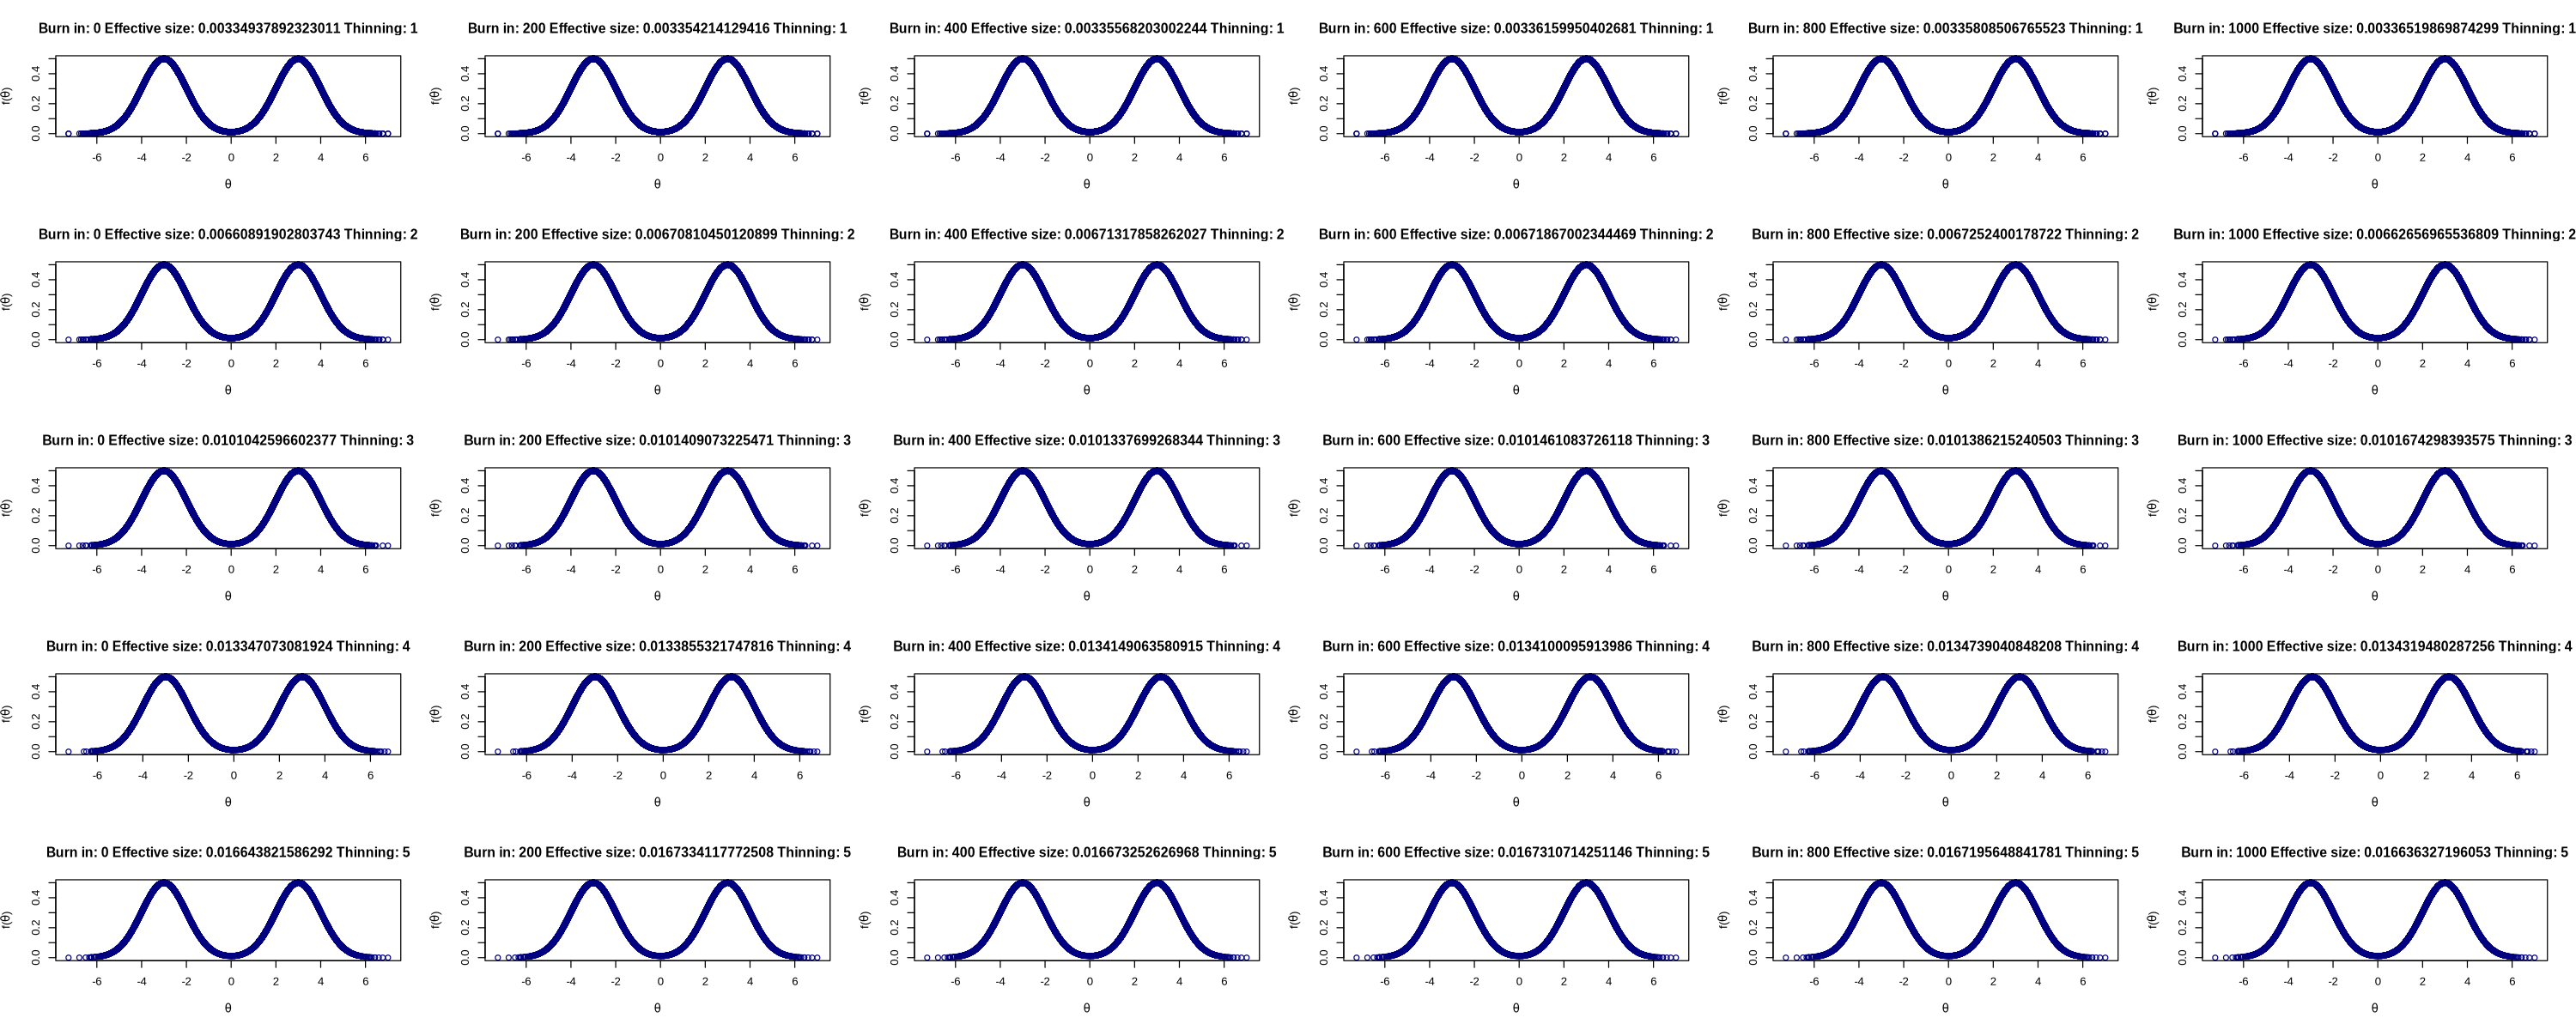

In [5]:
# Burn-in 
options(repr.plot.width = 25, repr.plot.height = 10)
data = data.frame(burn_in = numeric(), thinning = numeric(), effective_size = numeric())
par(mfrow = c(5, 6))
for (thin in 1:5) {
    thinning = seq(1, n_samples, thin)
    coda_chain_thin = coda_chain[thinning]
    #print(coda_chain)
    for (n_burn_in in seq(0, 1000, 200)) {
        burnt_chain = coda_chain_thin[(n_burn_in + 1):n_samples]
        #print(dim(burnt_chain))

        # Remove NA values from burnt_chain
        burnt_chain <- burnt_chain[!is.na(burnt_chain)]

        #print(burnt_chain)

        eff_size = effectiveSize(burnt_chain) / length(burnt_chain)

        new_row = data.frame(burn_in = n_burn_in, thinning = thin, effective_size = eff_size)
        data = rbind(data, new_row)

        func_res = array(gfunc(burnt_chain))
        #print(dim(func_res))
        theta_res = array(burnt_chain)
        #print(dim(theta_res))
        plot(theta_res, func_res, main = paste("Burn in:", n_burn_in, "Effective size:", eff_size, "Thinning:", thin), 
            col = 'navyblue', xlab = expression(theta), ylab = expression(paste('f(',theta,')')))
    }
}
#data
best_idx = which.min(data$effective_size)
best_params = c(data$burn_in[best_idx], data$thinning[best_idx])
print(paste("The best params are: burn in =", best_params[1], ", thinning =", best_params[2]))


# Exercise 2 #

A set of measured data should follow, according to the physics model applied to them, a linear
behavior. Data are the following:

| $\mathrm{Y}$ | -7.821 | -1.494 | -15.444 | -10.807 | -13.735 | -14.442 | -15.892 | -18.326 |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $\mathrm{X}$ | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 |

• perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS, assuming
that data follow the model:

$$
(\mathrm{Z}[\mathrm{i}]=\mathrm{a}+\mathrm{b} * \mathrm{X}[\mathrm{i}])
$$

•and the likelihood of the measured data follow a Gaussian likelihood distribution:
$$
 \mathrm{Y[i] \sim dnorm(Z[i], c)}
$$
•you can constrain the parameter a, b and c to the following intervals: a ∈ [1,10], b ∈ [−1,3] and
c ∈[0.034,4]

•run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution
of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for
the parameters.

•using the obtained posterior distributions, compute the posterior distribution of σ = 1/√c

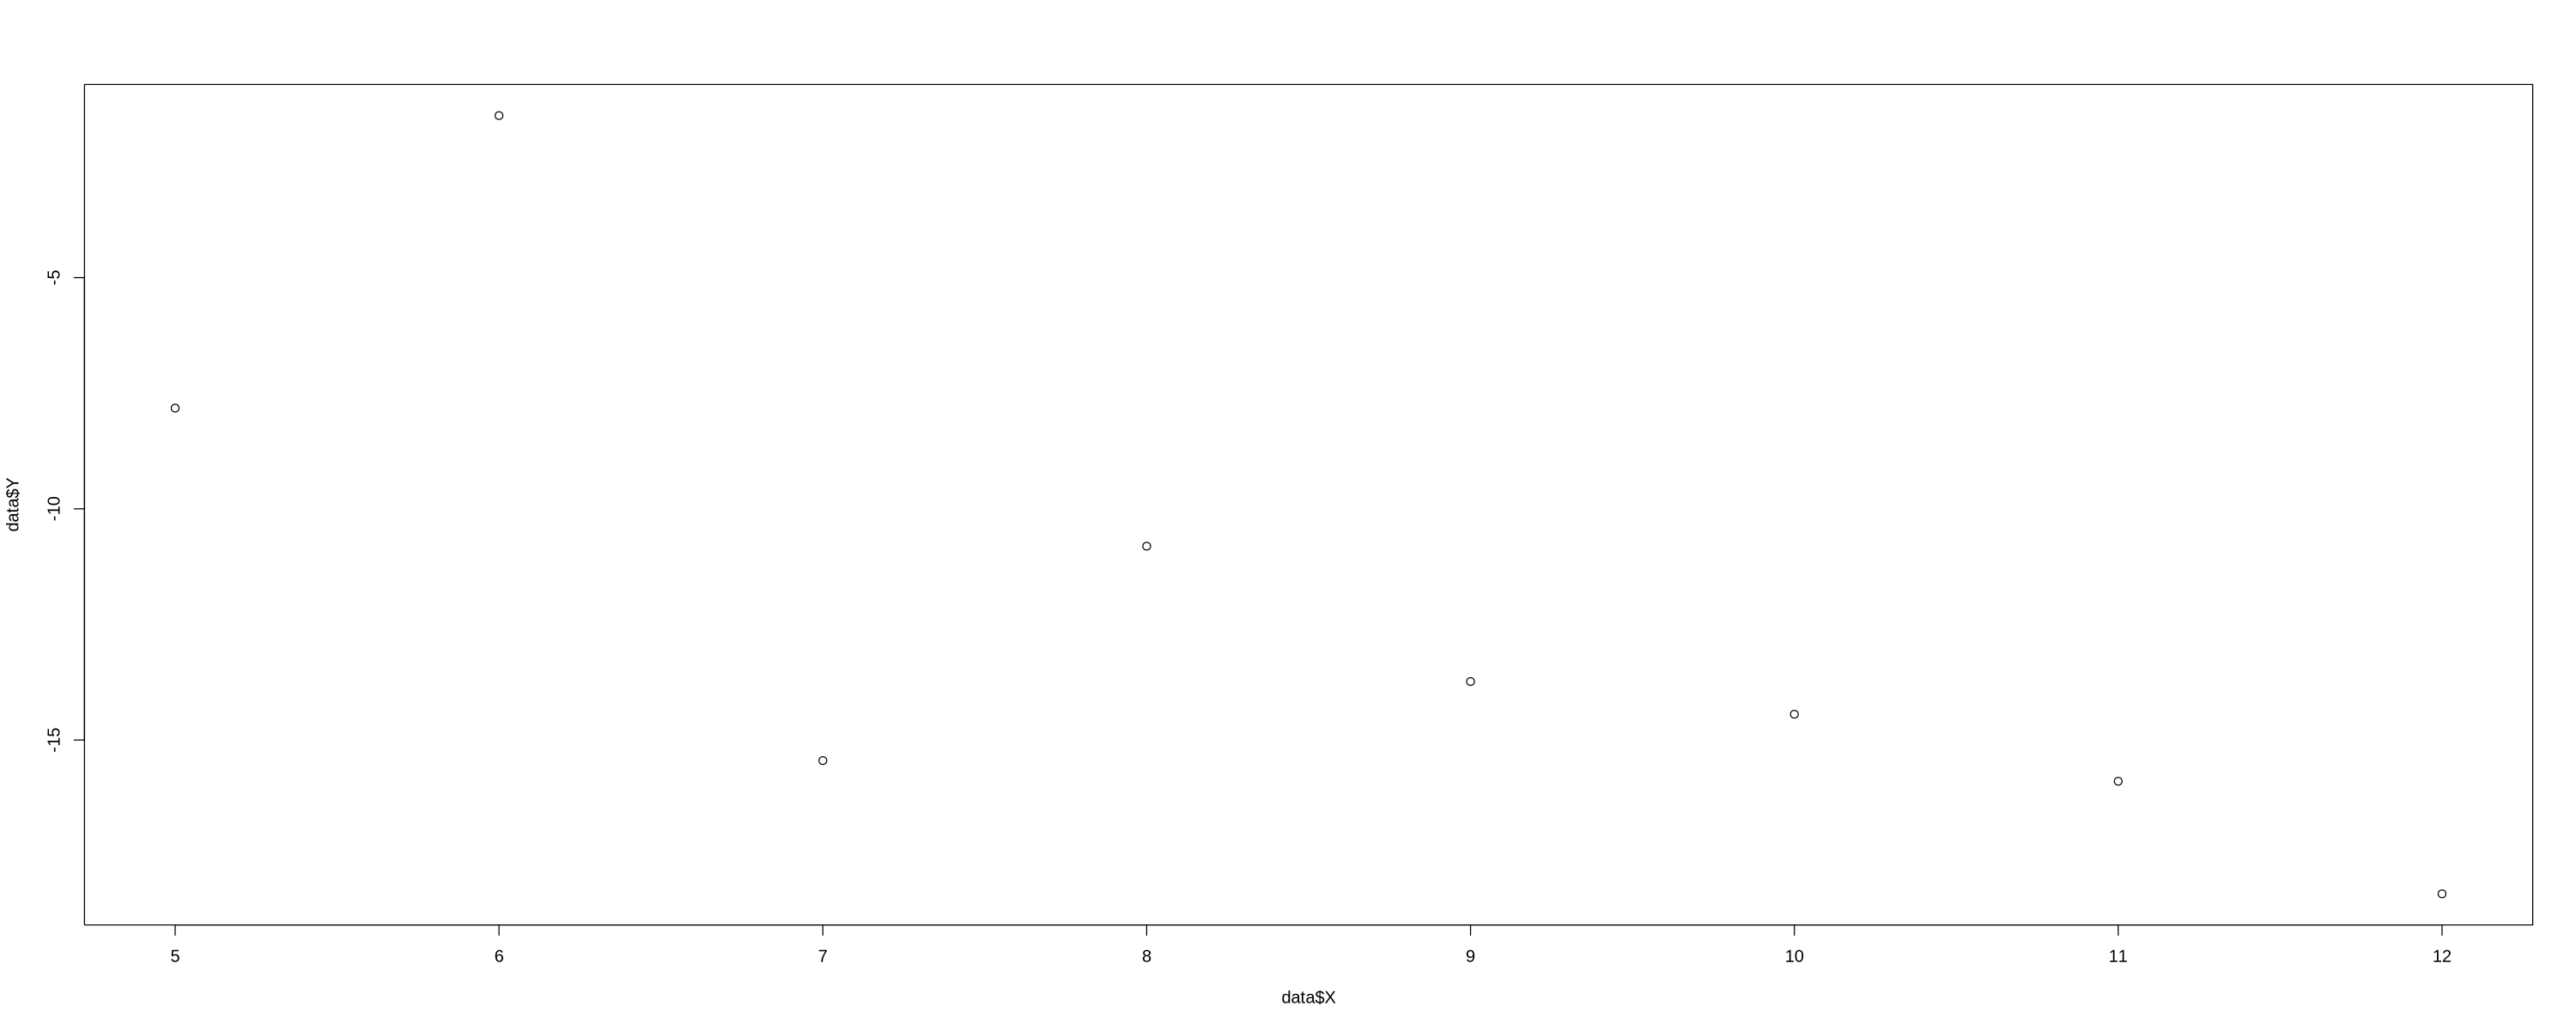

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)

Y <- c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)
X <- c( 5, 6, 7, 8, 9, 10, 11, 12)

data <- data.frame(X, Y)

plot(data$X, data$Y)

In [14]:
jagsdata <- with(data, list(X = X, Y = Y))

model <- function() {
    # data model
    for (i in 1:length(Y)) {
        Z[i] <-  a + b * X[i];

        # data likelihood
        Y[i] ~  dnorm(Z[i], c);
    }

    # parameters
    a ~ dunif(1, 10);
    b ~ dunif(-1, 3);
    c ~ dunif(0.034, 4);
}

init <- function() {
    list(a = runif(1, 1, 10), b = runif(1, -1, 3), c = runif(1, 0.034, 4))
}

params <- c("a", "b", "c")

jm <- jags(data = jagsdata, inits = init, parameters.to.save = params, model.file = model,
			n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)

jm

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 41

Initializing model



Inference for Bugs model at "/tmp/RtmpcUUl11/model763068f3e7c2.txt", fit using jags,
 3 chains, each with 12000 iterations (first 2000 discarded), n.thin = 10
 n.sims = 3000 iterations saved
  mu.vect sd.vect   2.5%    25%    50%    75%  97.5%  Rhat n.eff
a   1.477    0.45  1.013  1.144  1.354  1.678  2.649 1.001  3000
b  -0.948    0.05 -0.999 -0.986 -0.963 -0.927 -0.818 1.002  2100
c   0.044    0.01  0.034  0.037  0.041  0.049  0.070 1.001  2800

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

,mean,sd,2.5%,25%,50%,75%,97.5%,Rhat,n.eff
a,1.4771103,0.44968373,1.01294523,1.14385594,1.35408090,1.67807320,2.6491215,1.001044,3000
b,-0.9482337,0.04997577,-0.99858120,-0.98554027,-0.96308785,-0.92716293,-0.8180061,1.001545,2100
c,0.0443842,0.00968578,0.03434299,0.03716163,0.04145289,0.04878426,0.0699818,1.001224,2800


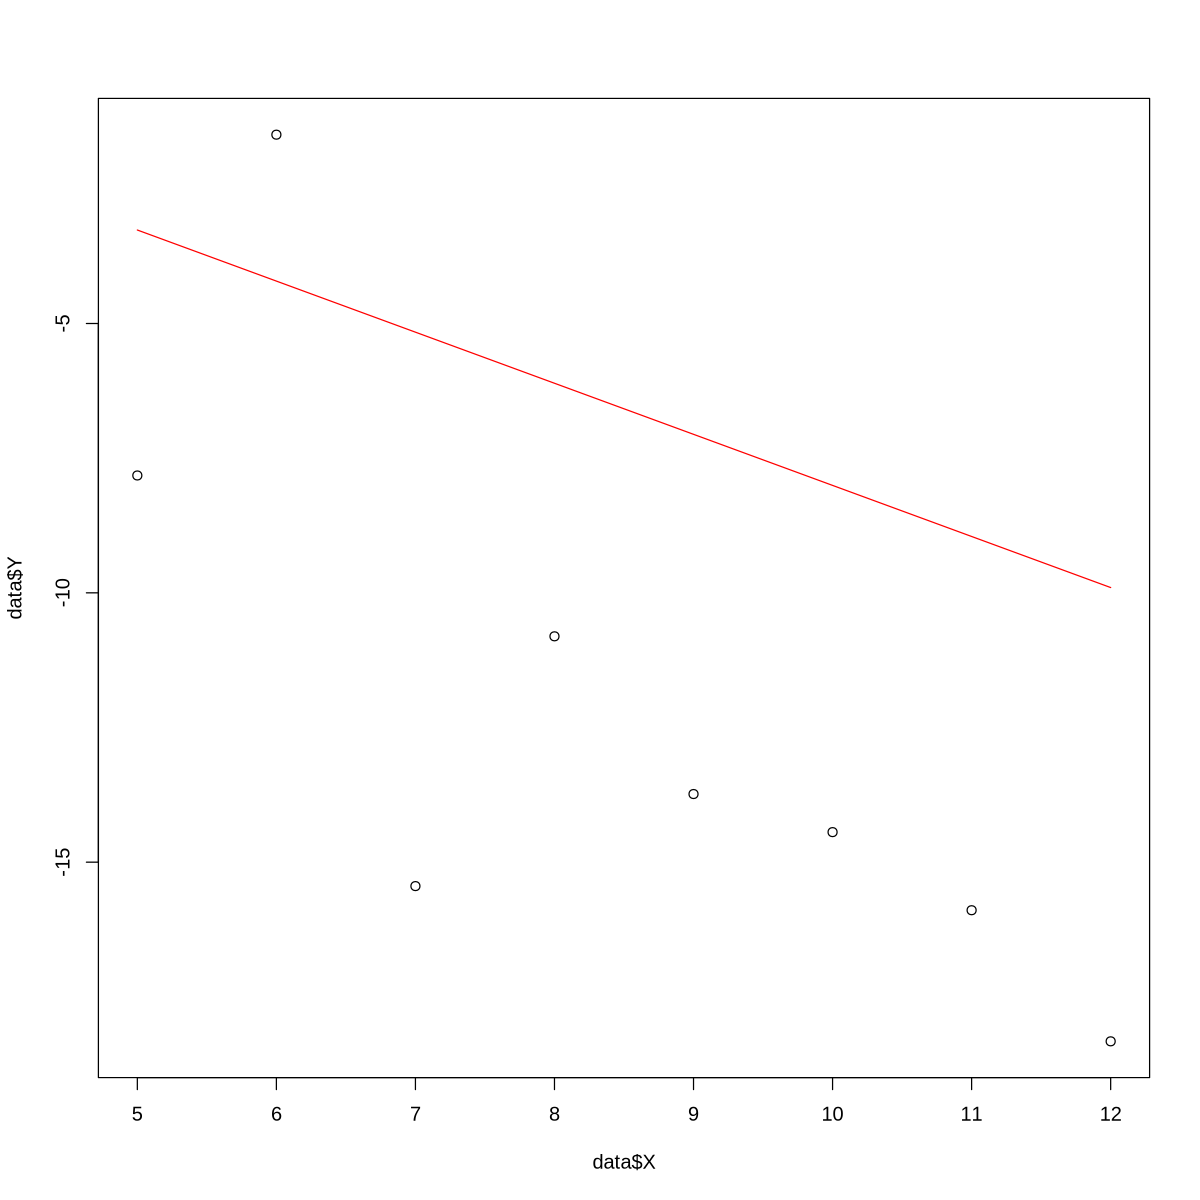

In [19]:
jm$BUGSoutput$summary

fit_params<-as.data.frame(jm$BUGSoutput$summary)["mean"]

x_fit<-seq(min(data$X),max(data$X),by = 0.01)
y_fit<-fit_params[1,] + fit_params[2,]*x_fit
plot(data$X,data$Y)
lines(x_fit,y_fit, col = 'red')

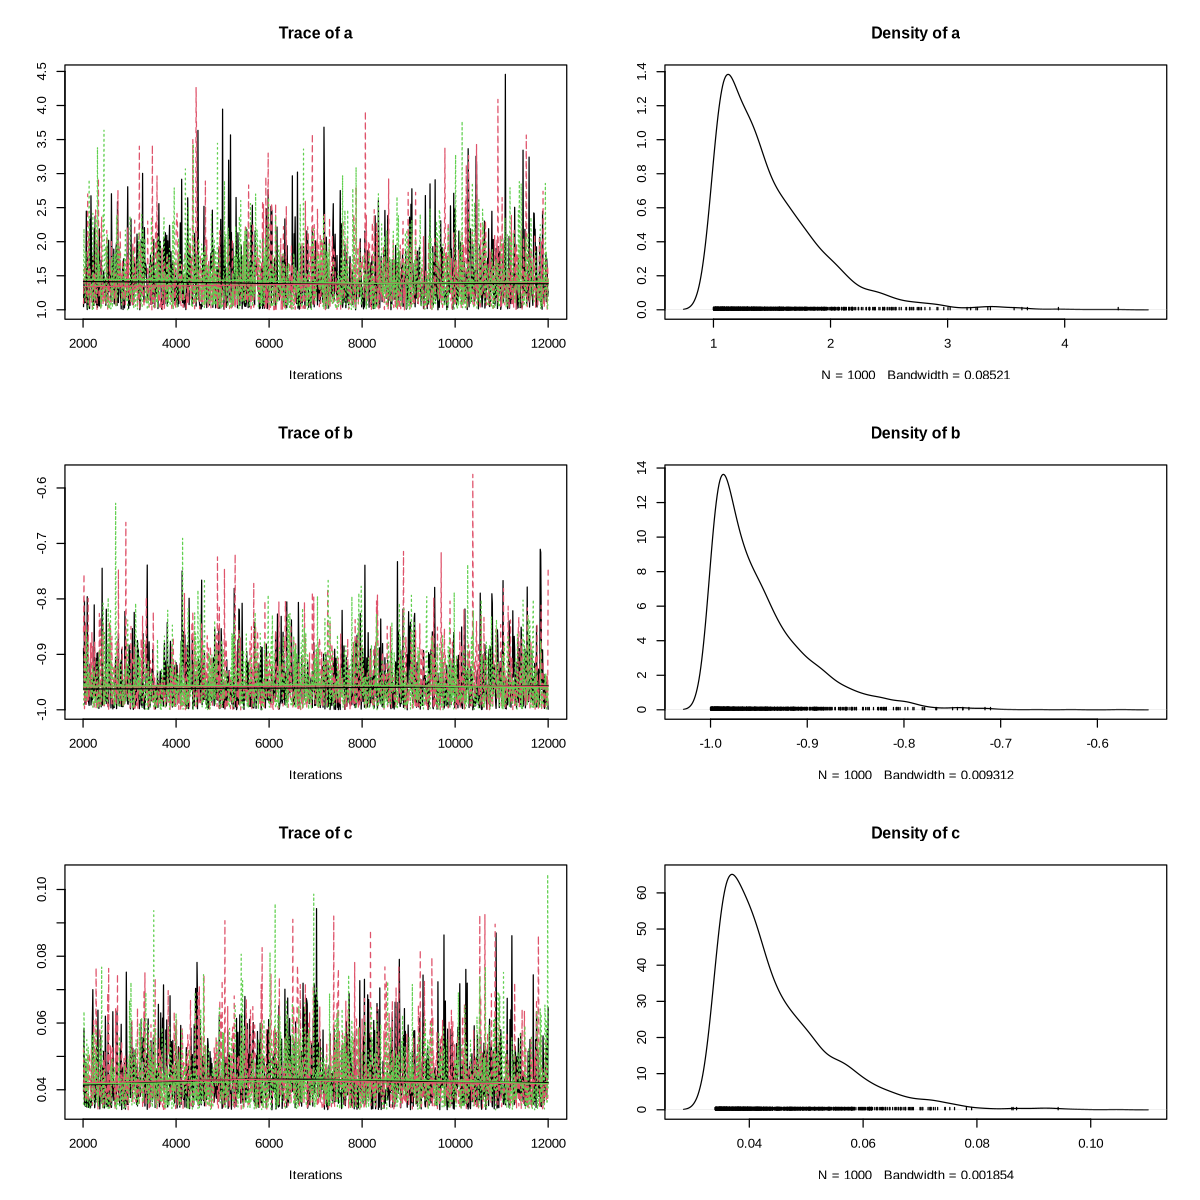

In [21]:
fit_chain <- as.mcmc(jm)
plot(fit_chain)

In [31]:
left_tail <- as.data.frame(jm$BUGSoutput$summary)["2.5%"]
rigth_tail <- as.data.frame(jm$BUGSoutput$summary)["97.5%"]

cat("Confidence intervals:")
for (i in 1:3) {
  cat(sprintf("\n%s : %f\t\t95%% CI : %f - %f", params[i], fit_params[i,], left_tail[i,], rigth_tail[i,]))
}

Confidence intervals:


a : 1.477110		95% CI : 1.012945 - 2.649121
b : -0.948234		95% CI : -0.998581 - -0.818006
c : 0.044384		95% CI : 0.034343 - 0.069982

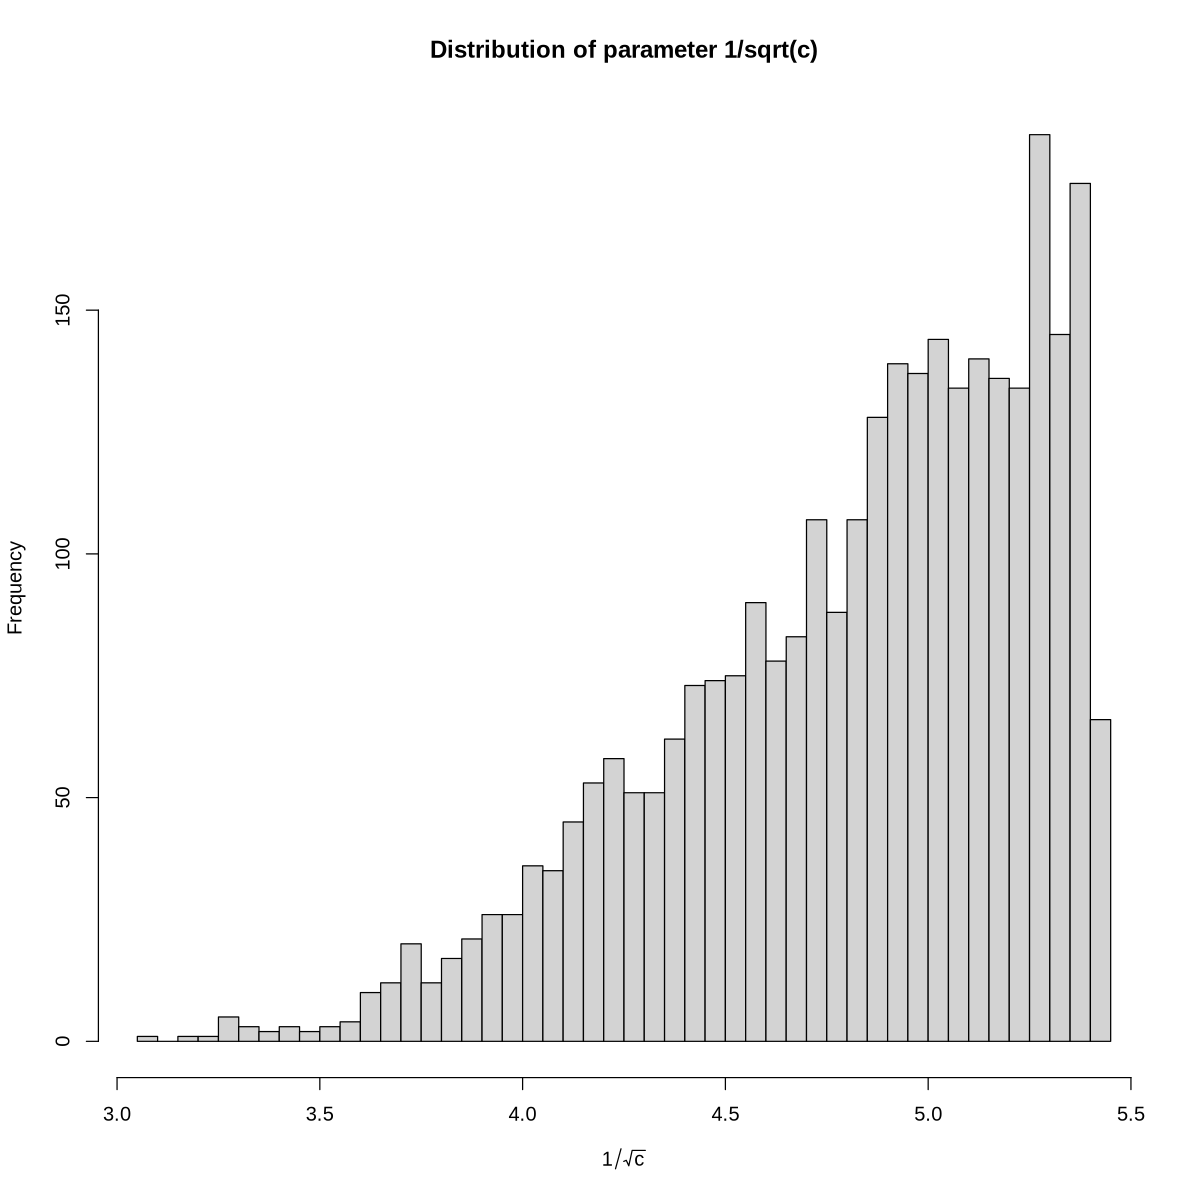

In [37]:
mkchain<-as.data.frame(jm$BUGSoutput$sims.matrix)

hist(1/sqrt(as.mcmc(mkchain["c"])),breaks = 50, 
    main = paste("Distribution of parameter", expression(1 / sqrt(c))), xlab = expression(1 / sqrt(c)))

# Exercise 3 #

•suppose we observe the following values

x = 2.06,5.56,7.93,6.56,205

•and we assume that the data come from a gaussian distribution with unknown mean m and variance $s^2$

•build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribu-
tion of the mean and variance.

•Assume uniform prior distributions for the parameters, m ~dunif(-10, 10) and s ~dunif(0,50).

•compute also the posterior distribution for m/s

In [40]:
X = c(2.06, 5.56, 7.93, 6.56, 205)

model <- function() {
    for (i in 1:length(X)) {
        X[i] ~ dnorm(m, s*s)
    }
    
    m ~ dunif(-10, 10)
    s ~ dunif(0,50)
}

init <- function() {
    list(m = runif(1, -10, 10), s = runif(1, 0, 50))
}

params <- c("m", "s")

data <- data.frame(X)

fit <- jags(data = data, inits = init, parameters.to.save = params, model.file = model,
			n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)

fit 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 12

Initializing model



Inference for Bugs model at "/tmp/RtmpcUUl11/model76306d2a8c11.txt", fit using jags,
 3 chains, each with 12000 iterations (first 2000 discarded), n.thin = 10
 n.sims = 3000 iterations saved
  mu.vect sd.vect   2.5%    25%   50%   75% 97.5%  Rhat n.eff
m   1.059   5.700 -9.324 -3.709 1.579 6.027 9.609 1.001  3000
s   0.011   0.003  0.005  0.009 0.011 0.014 0.018 1.001  3000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

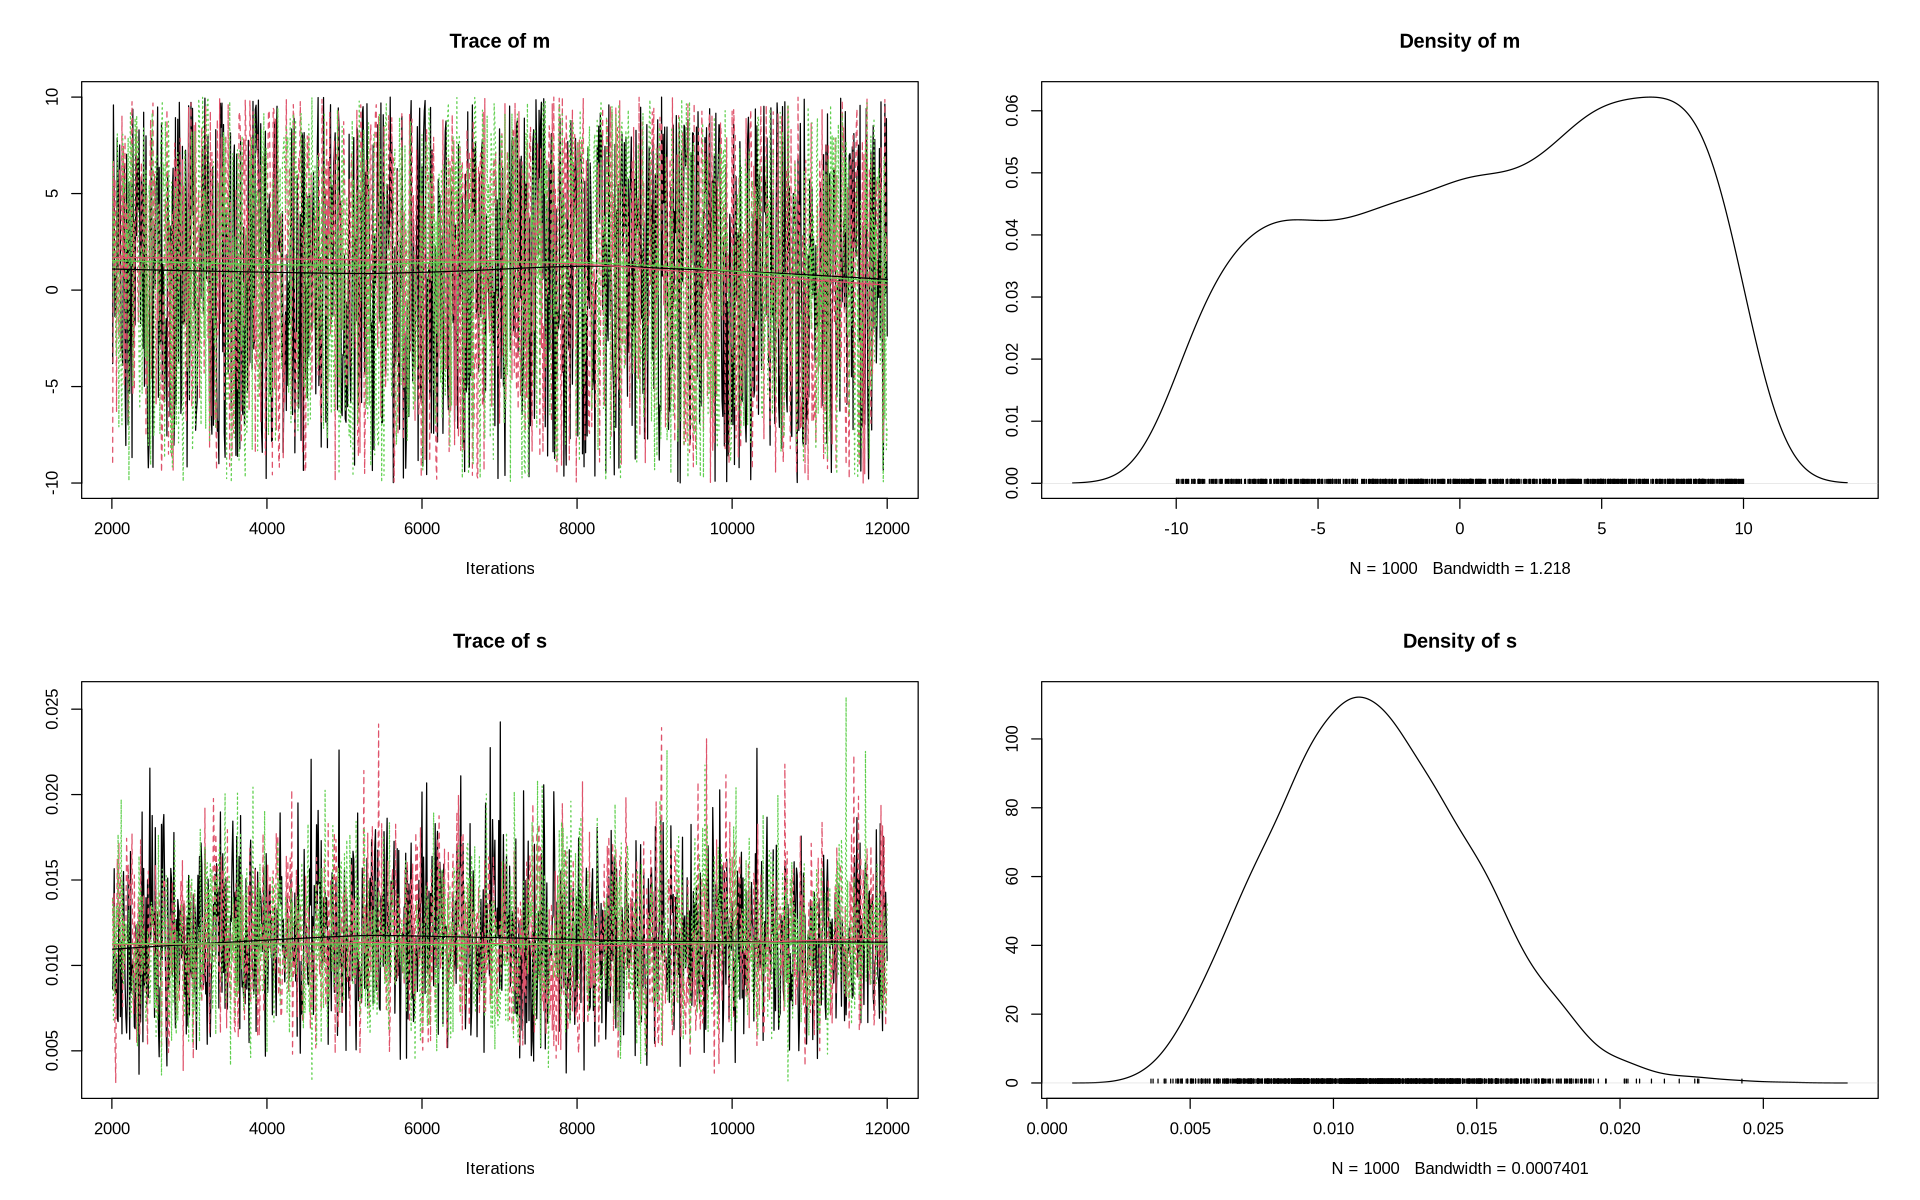

In [44]:
fit_chain<-as.mcmc(fit)
plot(fit_chain)

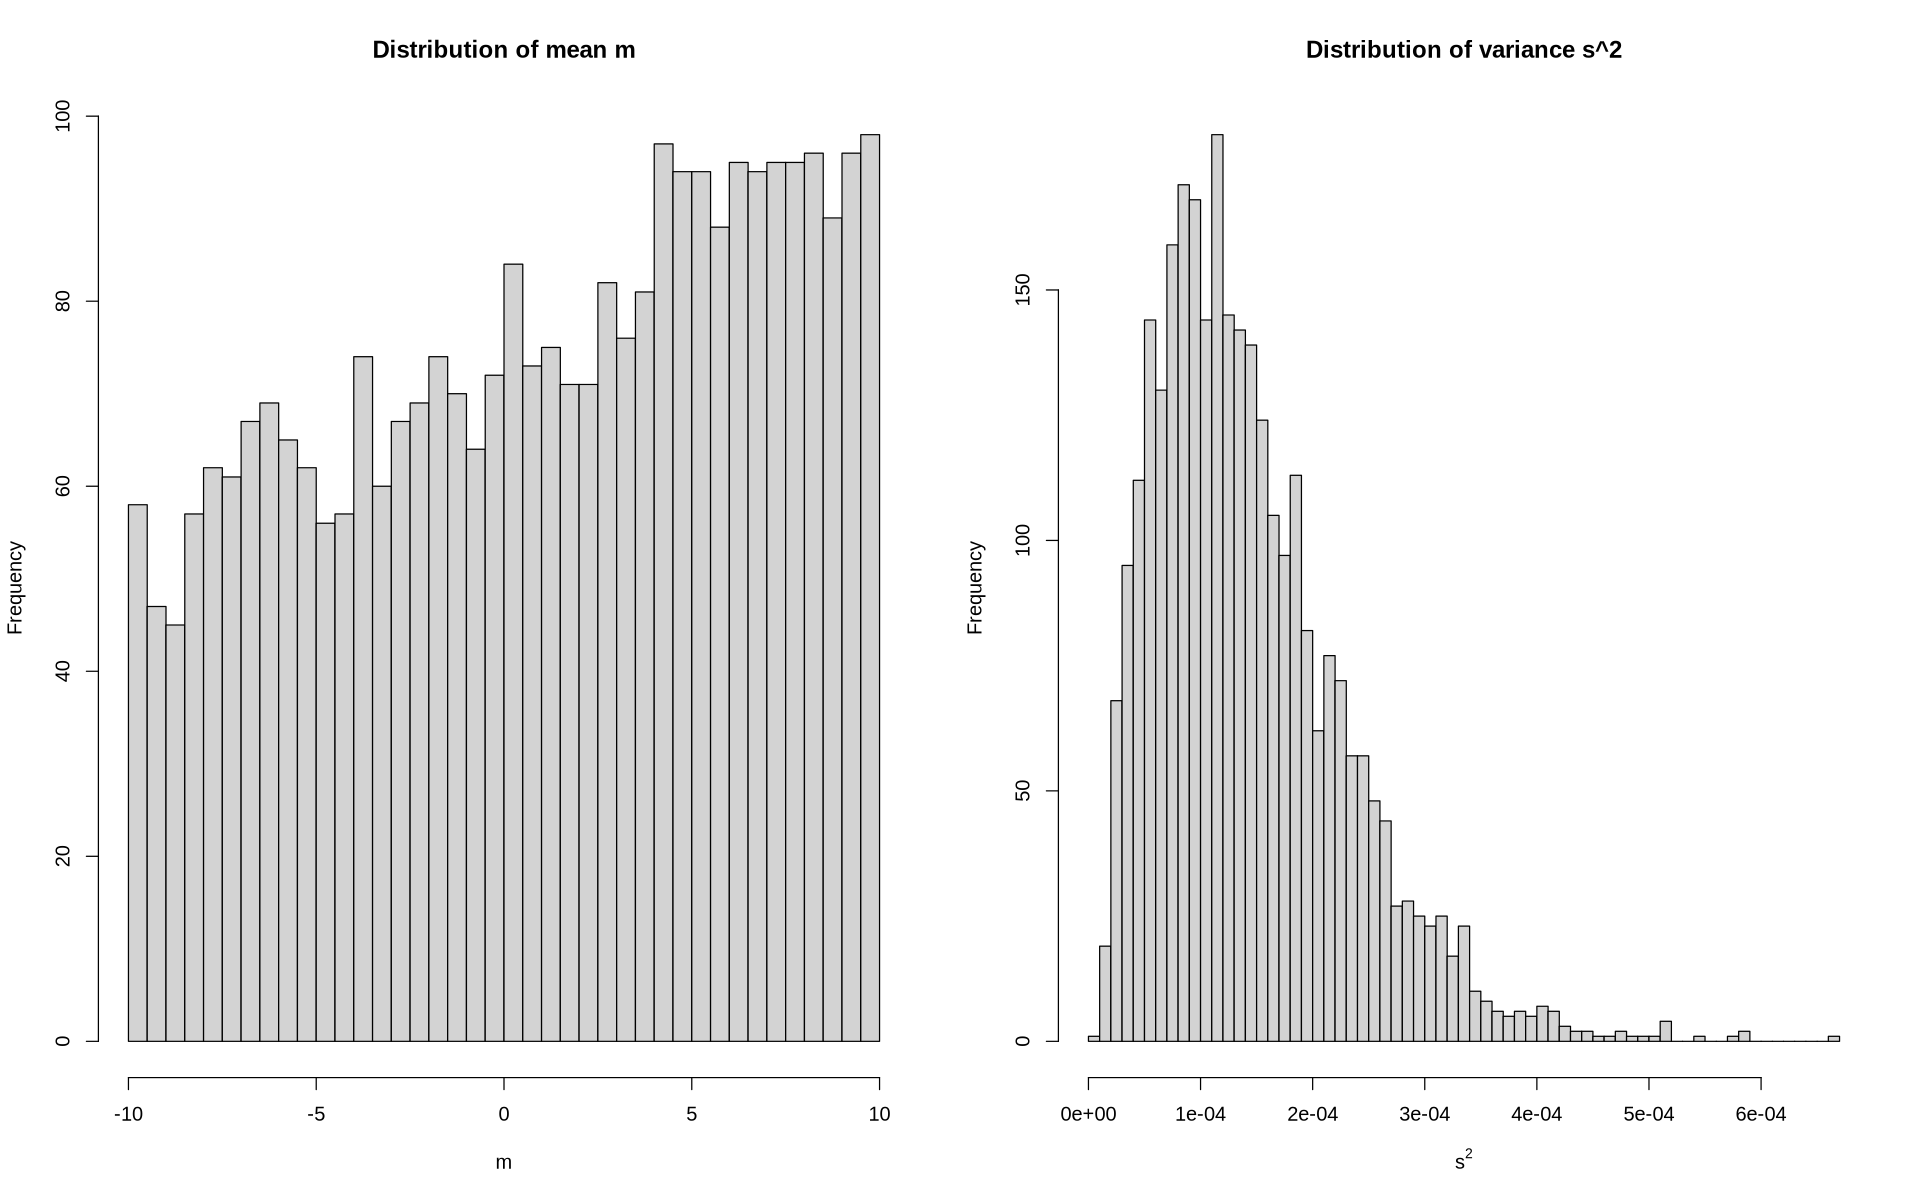

In [43]:
options(repr.plot.width = 16, repr.plot.height = 10)

matrix <- as.data.frame(fit$BUGSoutput$sims.matrix)

par(mfrow = c(1,2))
hist(as.mcmc(matrix["m"]),breaks = 50, 
    main = "Distribution of mean m", xlab = "m")

hist(as.mcmc(matrix["s"] * matrix["s"]),breaks = 50, 
    main = paste("Distribution of variance",expression(s^2)), xlab = expression(s^2))

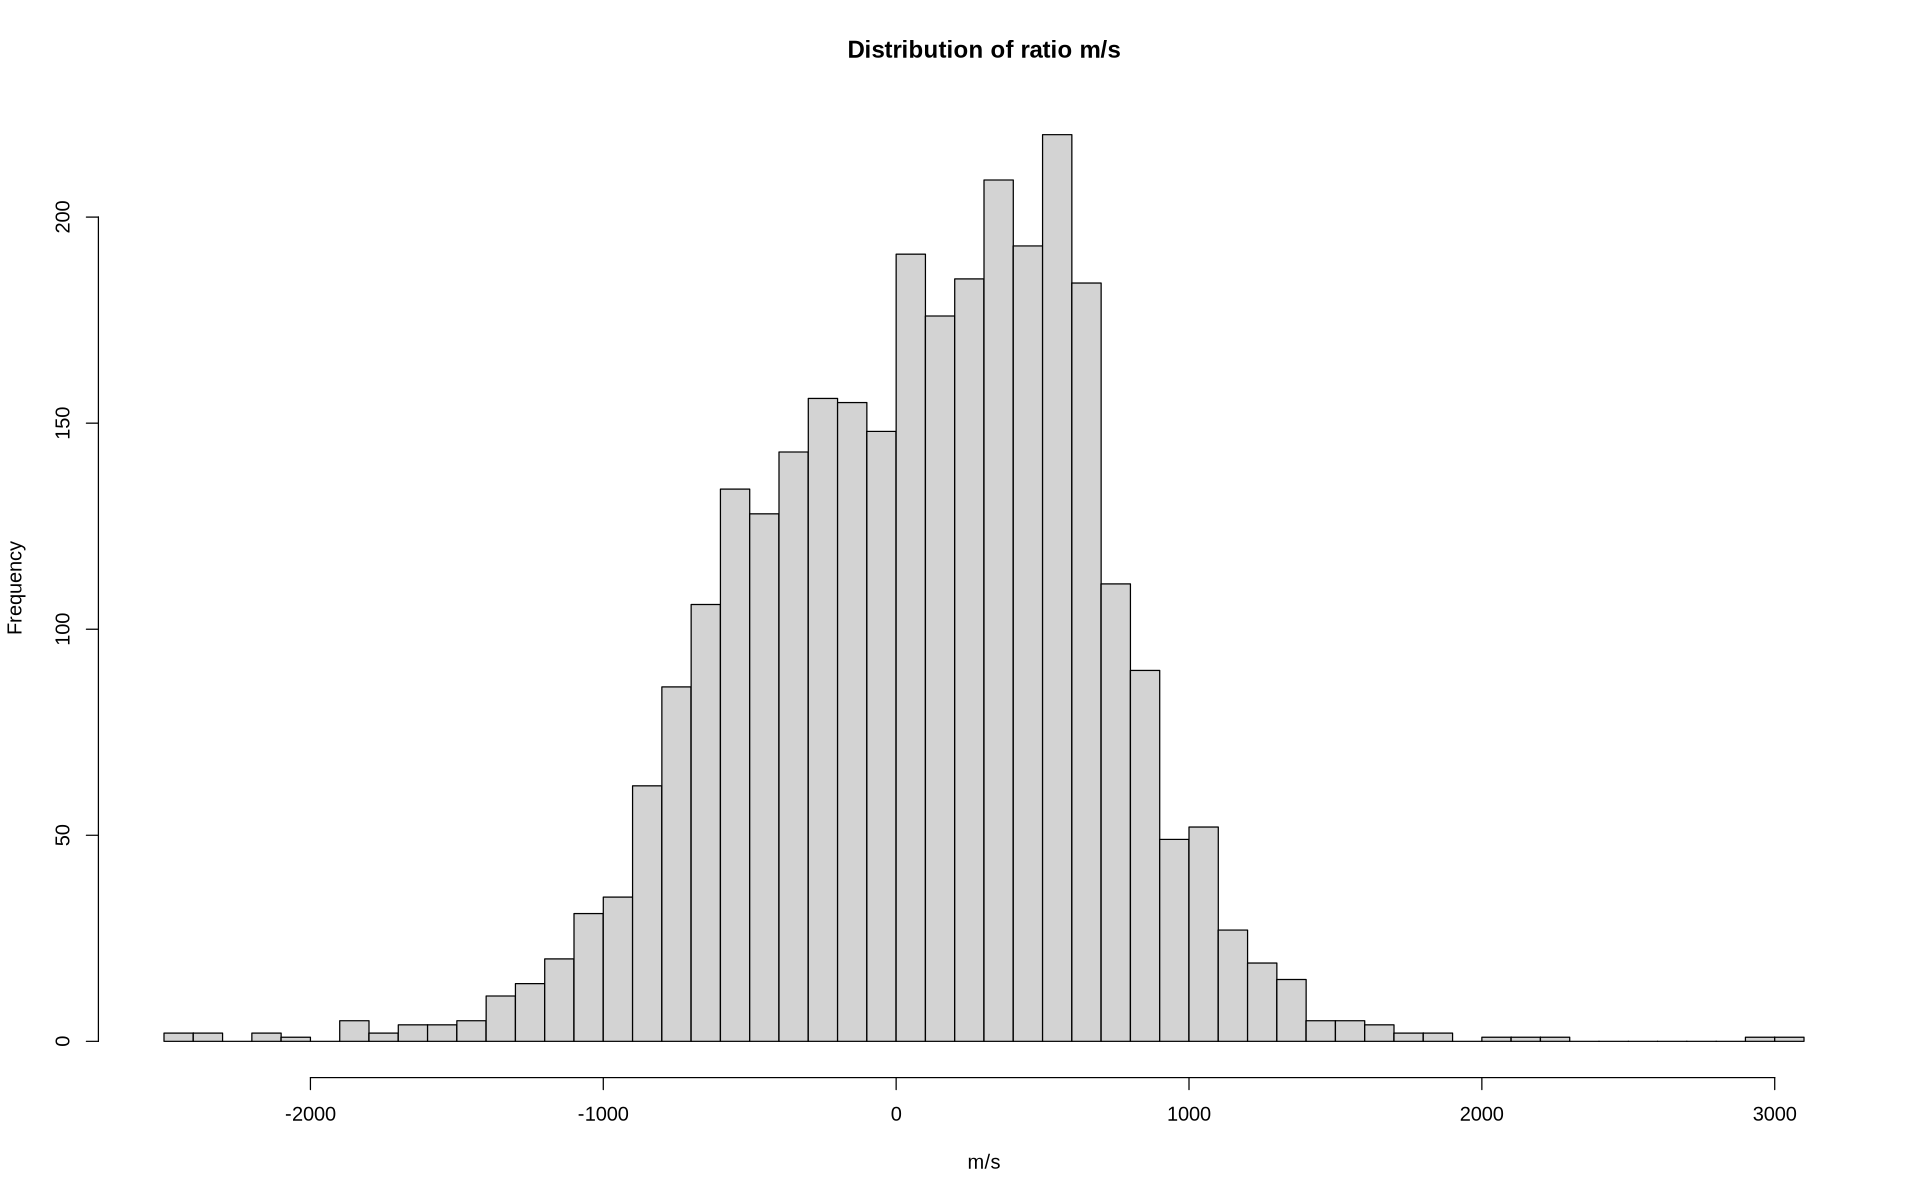

In [45]:
hist(as.mcmc(matrix["m"] / matrix["s"]),breaks = 50, 
    main = "Distribution of ratio m/s", xlab = "m/s")

# Exercise 4 #

•The data set that Edwin Hubble ised to show that galaxies are moving either away or towards us
are given in the following table:

| $\mathrm{D}$ | 0.0032 | 0.0034 | 0.214 | 0.263 | 0.275 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| $\mathrm{~V}$ | 170 | 290 | -130 | -70 | -185 |
| $\mathrm{D}$ | 0.275 | 0.45 | 0.5 | 0.5 | 0.63 |
| $\mathrm{~V}$ | -220 | 200 | 290 | 270 | 200 |
| $\mathrm{D}$ | 0.8 | 0.9 | 0.9 | 0.9 | 0.9 |
| $\mathrm{~V}$ | 920 | 450 | 500 | 500 | 960 |
| $\mathrm{D}$ | 2 | 2 | 2 | 2 |  |
| $\mathrm{~V}$ | 500 | 850 | 800 | 1090 |  |

•Using this data set define a JAGS model to fit data with the following:
$$
V[i] \sim dnorm(b * D[i], c)
$$

•where V represent the velocity in units of km/s, D is the observed distance (in units of parsec),
and b and c are two parameters of the model

•assume whatever prior distribution you think is appropriate

•plot the evolution of the chains, the posterior distribution of the parameters and the 95% credibility
interval

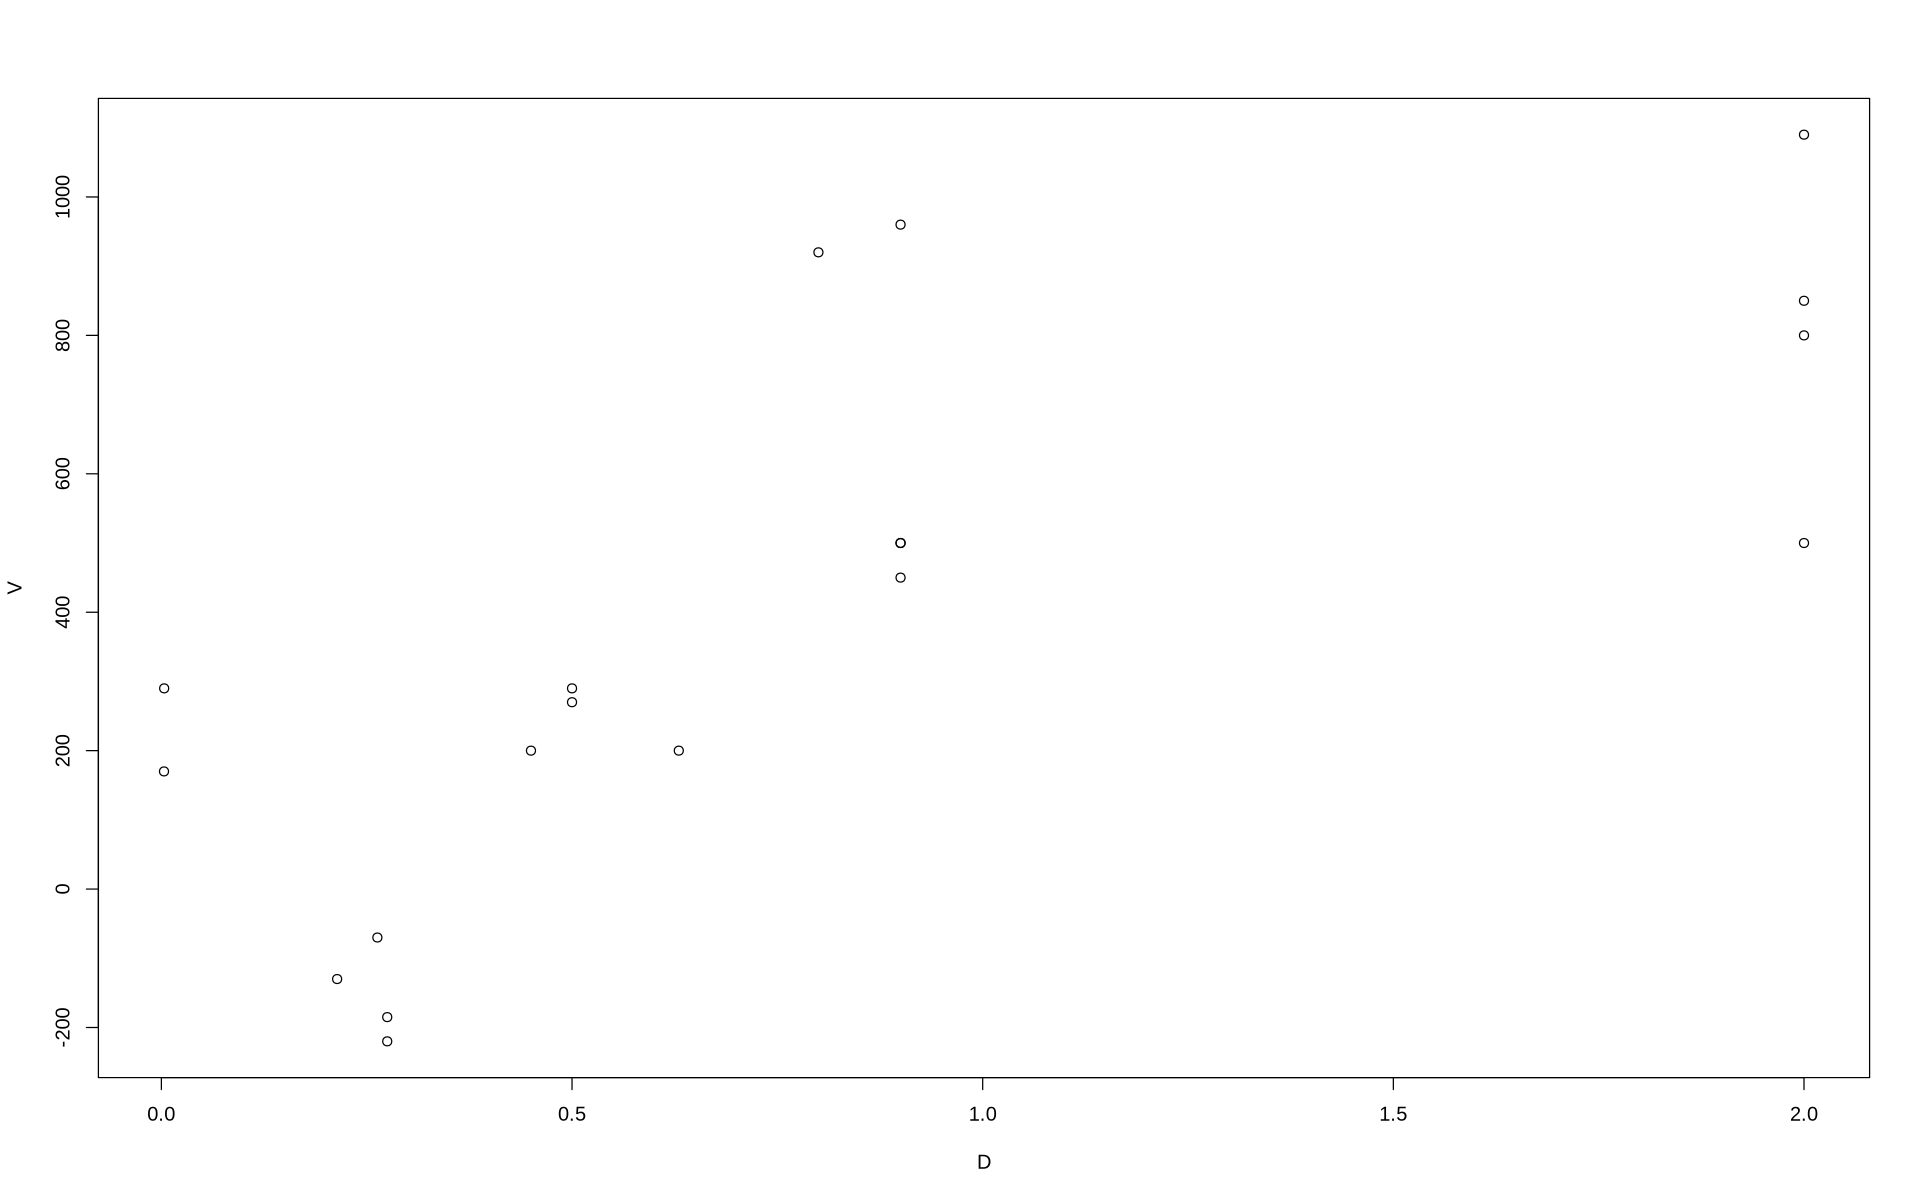

In [46]:
D <- c(0.0032, 0.0034, 0.214, 0.263, 0.275, 
       0.275, 0.45, 0.5, 0.5, 0.63, 
       0.8, 0.9, 0.9, 0.9, 0.9, 
       2, 2, 2, 2)

V <- c(170, 290, -130, -70, -185, 
       -220, 200, 290, 270, 200, 
       920, 450, 500, 500, 960, 
       500, 850, 800, 1090)

plot(D, V)

In [48]:
model <- function() {
    for (i in 1:length(D)) {
        V[i] ~ dnorm(b * D[i], c)
    }
    
    b ~ dunif(-10, 1000)
    c ~ dunif(0,10)
}

init <- function() {
    list(b = runif(1, -10, 1000), c = runif(1, 0, 10))
}

params <- c("b", "c")

data <- data.frame(D, V)

fit <- jags(data = data, inits = init, parameters.to.save = params, model.file = model,
			n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)

fit

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 55

Initializing model



Inference for Bugs model at "/tmp/RtmpcUUl11/model7630fdadc80.txt", fit using jags,
 3 chains, each with 12000 iterations (first 2000 discarded), n.thin = 10
 n.sims = 3000 iterations saved
  mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
b 456.574  58.072 341.952 416.749 456.886 494.842 567.316 1.001  3000
c   0.000   0.000   0.000   0.000   0.000   0.000   0.000 1.001  2800

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

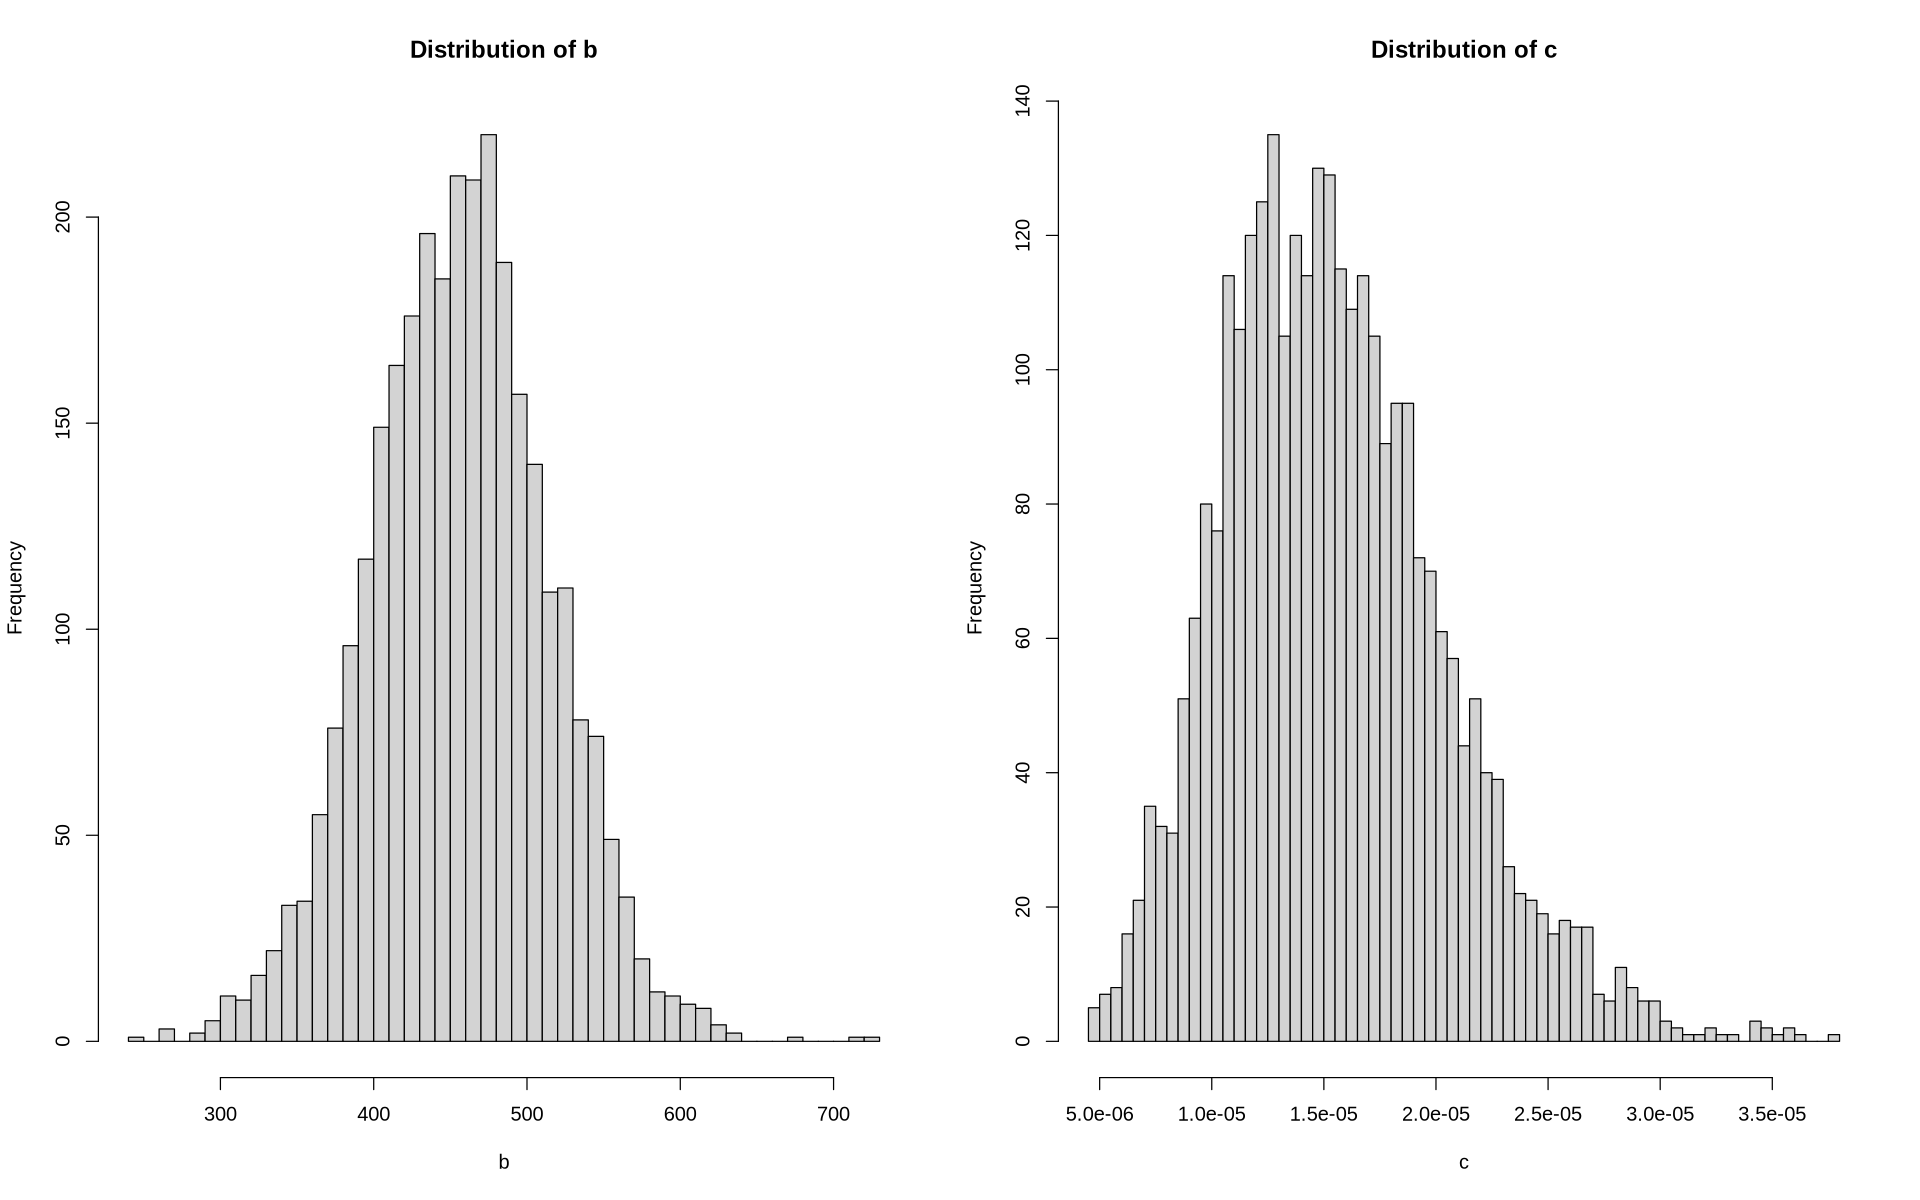

In [50]:
options(repr.plot.width = 16, repr.plot.height = 10)

matrix <- as.data.frame(fit$BUGSoutput$sims.matrix)

par(mfrow = c(1,2))
hist(as.mcmc(matrix["b"]),breaks = 50, 
    main = "Distribution of b", xlab = "b")

hist(as.mcmc(matrix["c"]),breaks = 50, 
    main = paste("Distribution of c"), xlab = "c")